In [2]:
#most positive, most negative, largest range, biggest reversal

# Load necessary libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


In [3]:
# File path to the Excel file
file_path = "data.xlsx"  # Replace with your actual file path

# Load the Excel file into a dictionary of DataFrames
try:
    # Read all sheets into a dictionary of DataFrames
    excel_data = pd.read_excel(os.path.join(os.getcwd(), "data", file_path), sheet_name=None)
    print("Excel file successfully loaded!")
    
    # Access specific sheets by name
    df_oct = excel_data.get("oct", pd.DataFrame())
    df_jan = excel_data.get("jan", pd.DataFrame())
    df_jan_summary = excel_data.get("jan_summary", pd.DataFrame())
    df_oct_summary = excel_data.get("oct_summary", pd.DataFrame())

    # Standardize the column name for 'anonymous signal'
    if 'anonymous signal #' in df_oct.columns:
        df_oct.rename(columns={'anonymous signal #': 'anonymous signal'}, inplace=True)
    if 'anonymous signal #' in df_jan.columns:
        df_jan.rename(columns={'anonymous signal #': 'anonymous signal'}, inplace=True)

    if 'anonymous signal' not in df_oct.columns:
        print("Error: Missing 'anonymous signal' column in df_oct_summary")
    if 'anonymous signal' not in df_jan.columns:
        print("Error: Missing 'anonymous signal' column in df_jan_summary")

except FileNotFoundError:
    print(f"File not found: {file_path}. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")


# Ensure the 'Date' column is in datetime format
df_oct['Date'] = pd.to_datetime(df_oct['Date'])

# Filter rows where the month is in September (9), October (10), or November (11)
df_oct_filtered = df_oct[df_oct['Date'].dt.month.isin([9, 10, 11])]


# Combine the two DataFrames
df_combined = pd.concat([df_jan_summary, df_oct_summary], ignore_index=True)
# Combine the two DataFrames
df_combined_backtest = pd.concat([df_jan, df_oct_filtered], ignore_index=True)

# Create a DataFrame for rows with NaN values
exemption_list = df_combined[df_combined.isnull().any(axis=1)]
exemption_list_backtest = df_combined_backtest[df_combined_backtest.isnull().any(axis=1)]

# Drop rows with NaN values from the combined DataFrame
df_combined = df_combined.dropna()
df_combined_backtest = df_combined_backtest.dropna()

Excel file successfully loaded!


In [4]:
# Assuming 'df' is your DataFrame
columns_to_average = [
    "Reversal_Frequency",
    "Average_Return",
    "Max_Positive_Return",
    "Max_Negative_Return",
    "Forward_1D_Return_Avg",
    "Forward_2D_Return_Avg",
    "Forward_3D_Return_Avg",
    "Forward_4D_Return_Avg",
    "Forward_5D_Return_Avg",
    "Two_Day_Reversal_Return_Avg"
]

# Group by 'anonymous signal' and calculate the mean for the specified columns
df_combined_avg = (
    df_combined.groupby("anonymous signal", as_index=False)[columns_to_average].mean()
)

# Optionally handle the 'Ticker' column, for example by concatenating unique tickers for each signal
df_combined_avg["Ticker"] = (
    df_combined.groupby("anonymous signal")["Ticker"]
    .apply(lambda x: ', '.join(x.unique()))  # Concatenate unique tickers
    .reset_index(drop=True)
)


In [5]:
# List of columns to apply clustering (excluding Ticker and any non-numeric columns)
columns_to_cluster = [
    "Reversal_Frequency",
    "Average_Return",
    "Max_Positive_Return",
    "Max_Negative_Return",
    "Forward_1D_Return_Avg",
    "Forward_2D_Return_Avg",
    "Forward_3D_Return_Avg",
    "Forward_4D_Return_Avg",
    "Forward_5D_Return_Avg",
    "Two_Day_Reversal_Return_Avg"
]

# Define bin labels
cluster_labels = ["low", "med", "high"]

# Perform KMeans clustering for each column
for column in columns_to_cluster:
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df_combined_avg[f"{column}_Cluster"] = kmeans.fit_predict(df_combined_avg[[column]])
    
    # Sort clusters by their centroids
    centroids = kmeans.cluster_centers_.flatten()
    sorted_clusters = np.argsort(centroids)
    
    # Map clusters to bin labels
    cluster_to_bin = {sorted_clusters[i]: cluster_labels[i] for i in range(len(cluster_labels))}
    df_combined_avg[f"{column}_bin"] = df_combined_avg[f"{column}_Cluster"].map(cluster_to_bin)
    
    # Drop intermediate cluster column if not needed
    df_combined_avg.drop(columns=[f"{column}_Cluster"], inplace=True)


In [6]:
# Ensure non-numeric columns are excluded
numeric_columns = df_combined_avg.select_dtypes(include=["number"])

# Calculate short-term and long-term trends
df_combined_avg["Short_MA"] = numeric_columns["Average_Return"].rolling(window=3).mean()
df_combined_avg["Long_MA"] = numeric_columns["Average_Return"].rolling(window=10).mean()

# Identify trend changes
df_combined_avg["Trend_Change"] = (df_combined_avg["Short_MA"] > df_combined_avg["Long_MA"]).astype(int)

# Correlation with trend changes
# trend_corr = numeric_columns.corr()["Trend_Change"].sort_values(ascending=False)

# Forward fill and backward fill Short_MA and Long_MA without inplace
df_combined_avg["Short_MA"] = df_combined_avg["Short_MA"].ffill().bfill()
df_combined_avg["Long_MA"] = df_combined_avg["Long_MA"].ffill().bfill()


In [7]:
# List of return columns to filter on
return_columns = [
    'Average_Return', 
    'Forward_1D_Return_Avg', 
    'Forward_2D_Return_Avg', 
    'Forward_3D_Return_Avg', 
    'Forward_4D_Return_Avg', 
    'Forward_5D_Return_Avg'
]

# Iterate over each return column and filter
for column in return_columns:
    print(f"\nUnique signals where {column}_bin is 'low':")
    
    # Filter for 'low'
    filtered_df_low = df_combined_avg[df_combined_avg[f'{column}_bin'] == 'low']
    unique_signals_low = filtered_df_low['anonymous signal'].unique()
    print(unique_signals_low)
    
    print(f"\nUnique signals where {column}_bin is 'med' or 'high':")
    
    # Filter for 'med' or 'high'
    filtered_df_med_high = df_combined_avg[
        (df_combined_avg[f'{column}_bin'] == 'med') |
        (df_combined_avg[f'{column}_bin'] == 'high')
    ]
    unique_signals_med_high = filtered_df_med_high['anonymous signal'].unique()
    print(unique_signals_med_high)



Unique signals where Average_Return_bin is 'low':
[ 10  12  13  14  17  18  19  20  21  22  24  25  26  27  28  29  30  31
  32  33  34  35  36  37  38  39  40  41  42  43  45  49  50 129 131 134
 135 140]

Unique signals where Average_Return_bin is 'med' or 'high':
[  8  16  23  44  46  47  48  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 130 132 133 136 137
 138 139 144 145]

Unique signals where Forward_1D_Return_Avg_bin is 'low':
[ 17 138 139]

Unique signals where Forward_1D_Return_Avg_bin is 'med' or 'high':
[  8  10  12  13  14  16  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  6

Strategy:

Unique signals where Average_Return_bin is 'low':
[ 10  12  13  14  17  18  19  20  21  22  24  25  26  27  28  29  30  31
  32  33  34  35  36  37  38  39  40  41  42  43  45  49  50 129 131 134
 135 140]

Unique signals where Average_Return_bin is 'med' or 'high':
[  8  16  23  44  46  47  48  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 130 132 133 136 137
 138 139 144 145]

Unique signals where Forward_1D_Return_Avg_bin is 'low':
[ 17 138 139]

Unique signals where Forward_1D_Return_Avg_bin is 'med' or 'high':
[  8  10  12  13  14  16  18  19  20  21  22  23  24  25  26  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 140 144 145]

Unique signals where Forward_2D_Return_Avg_bin is 'low':
[ 13  14  17  18  19  21  23  24  25  26  27  28  29  31  32  34  35  36
  37  44  46  53  54  55  56  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 131 134 139
 140]

Unique signals where Forward_2D_Return_Avg_bin is 'med' or 'high':
[  8  10  12  16  20  22  30  33  38  39  40  41  42  43  45  47  48  49
  50  51  52  57 105 121 122 123 124 125 126 127 128 129 130 132 133 135
 136 137 138 144 145]

Unique signals where Forward_3D_Return_Avg_bin is 'low':
[ 13  14  17  18  19  21  22  23  24  25  26  27  28  29  31  32  34  35
  36  37  44  46  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 123 124 129 130 131 133 134 139 140]

Unique signals where Forward_3D_Return_Avg_bin is 'med' or 'high':
[  8  10  12  16  20  30  33  38  39  40  41  42  43  45  47  48  49  50
  51 121 122 125 126 127 128 132 135 136 137 138 144 145]

Unique signals where Forward_4D_Return_Avg_bin is 'low':
[ 13  14  17  18  19  21  22  23  24  25  26  27  28  29  31  32  34  35
  36  37  43  44  46  53  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 124 129 130 131 133 134 138 139 140]

Unique signals where Forward_4D_Return_Avg_bin is 'med' or 'high':
[  8  10  12  16  20  30  33  38  39  40  41  42  45  47  48  49  50  51
  52  54 122 123 125 126 127 128 132 135 136 137 144 145]

Unique signals where Forward_5D_Return_Avg_bin is 'low':
[ 13  14  17  18  19  21  22  23  24  25  27  29  31  32  34  35  36  37
  44  46  53  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69
  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 129 130 131
 133 134 137 138 139 140]

Unique signals where Forward_5D_Return_Avg_bin is 'med' or 'high':
[  8  10  12  16  20  26  28  30  33  38  39  40  41  42  43  45  47  48
  49  50  51  52  54 121 122 123 124 125 126 127 128 132 135 136 144 145]

In [8]:
# Convert 'Date' column to datetime
df_combined_backtest['Date'] = pd.to_datetime(df_combined_backtest['Date'])

df_combined_backtest['strike_price'] = (
    (df_combined_backtest['Best_Buy_Last'] + df_combined_backtest['Worst_Buy_Last']) / 2
).round(2)


In [9]:
df_combined_backtest

,Date,Best_Buy_Time,Best_Buy_Return,anonymous signal,Best_Buy_Last,Worst_Buy_Time,Worst_Buy_Return,Worst_Buy_Sorted_String2,Worst_Buy_Last,Stock,strike_price
0,2024-01-02,2024-01-02 15:04:00,8.96,81,137.46,2024-01-02 09:35:00,1.57,61,143.08,AMD,140.27
1,2024-01-03,2024-01-03 10:39:00,10.94,82,133.86,2024-01-03 10:04:00,7.50,78,136.71,AMD,135.29
2,2024-01-04,2024-01-04 09:41:00,10.63,79,135.82,2024-01-04 11:45:00,4.58,87,137.59,AMD,136.70
3,2024-01-05,2024-01-05 09:44:00,7.93,81,137.52,2024-01-05 10:56:00,3.53,41,140.11,AMD,138.82
4,2024-01-08,2024-01-08 10:48:00,10.27,58,144.23,2024-01-08 14:19:00,6.21,89,146.91,AMD,145.57
...,...,...,...,...,...,...,...,...,...,...,...
264,2024-10-17,2024-10-17 15:38:00,19.04,102,219.74,2024-10-17 09:30:00,10.47,56,220.19,TSLA,219.96
265,2024-10-18,2024-10-18 09:47:00,22.19,47,220.19,2024-10-18 09:30:00,16.43,50,221.32,TSLA,220.76
266,2024-10-21,2024-10-21 10:45:00,25.19,69,218.17,2024-10-21 15:59:00,19.95,92,218.85,TSLA,218.51
267,2024-10-22,2024-10-22 09:30:00,21.79,65,216.23,2024-10-22 12:56:00,18.10,75,216.76,TSLA,216.50


In [10]:
# Automatically determine buy and sell signals for each return strategy
return_columns = [
    'Average_Return_bin',
    'Forward_1D_Return_Avg_bin',
    'Forward_2D_Return_Avg_bin',
    'Forward_3D_Return_Avg_bin',
    'Forward_4D_Return_Avg_bin',
    'Forward_5D_Return_Avg_bin'
]

# Initialize dictionaries for buy and sell signals
buy_signals = {}
sell_signals = {}

for column in return_columns:
    # Extract unique signals where the bin is 'low' (buy)
    buy_signals[column] = df_combined_avg.loc[df_combined_avg[column] == 'low', 'anonymous signal'].unique()
    # Extract unique signals where the bin is 'med' or 'high' (sell)
    sell_signals[column] = df_combined_avg.loc[df_combined_avg[column].isin(['med', 'high']), 'anonymous signal'].unique()



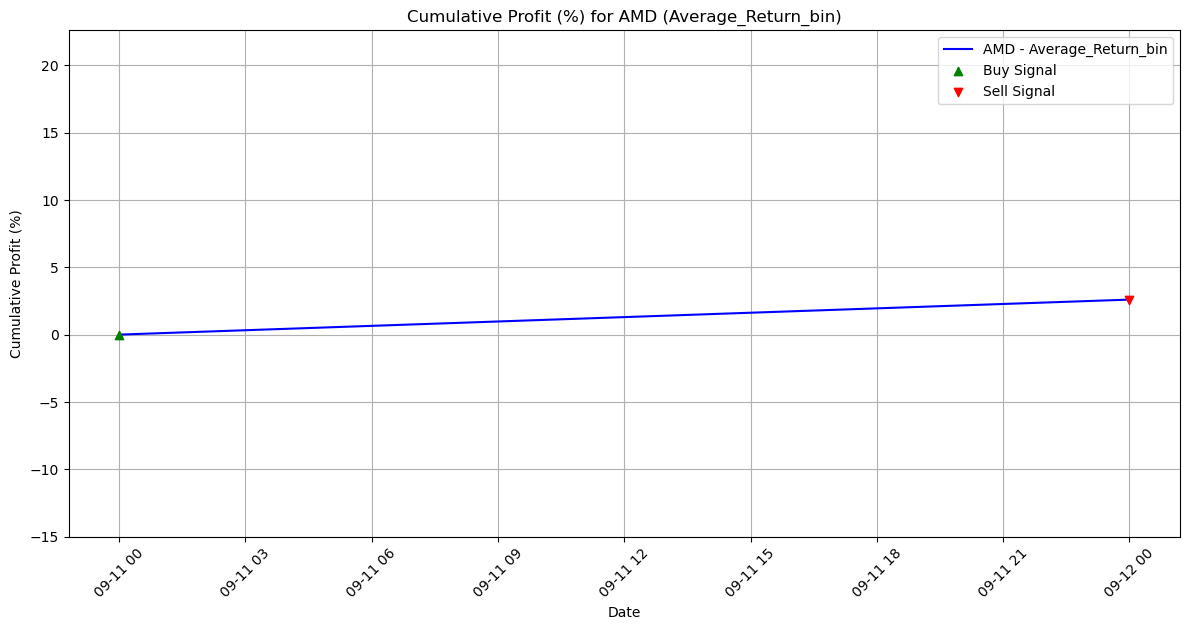

Transaction Steps for AMD (Average_Return_bin):
Buy Signal 49: Bought at 145.42 on 2024-09-11
Sell Signal 91: Sold at 149.2 on 2024-09-12
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------

No valid data to plot for AMD - Forward_1D_Return_Avg_bin.


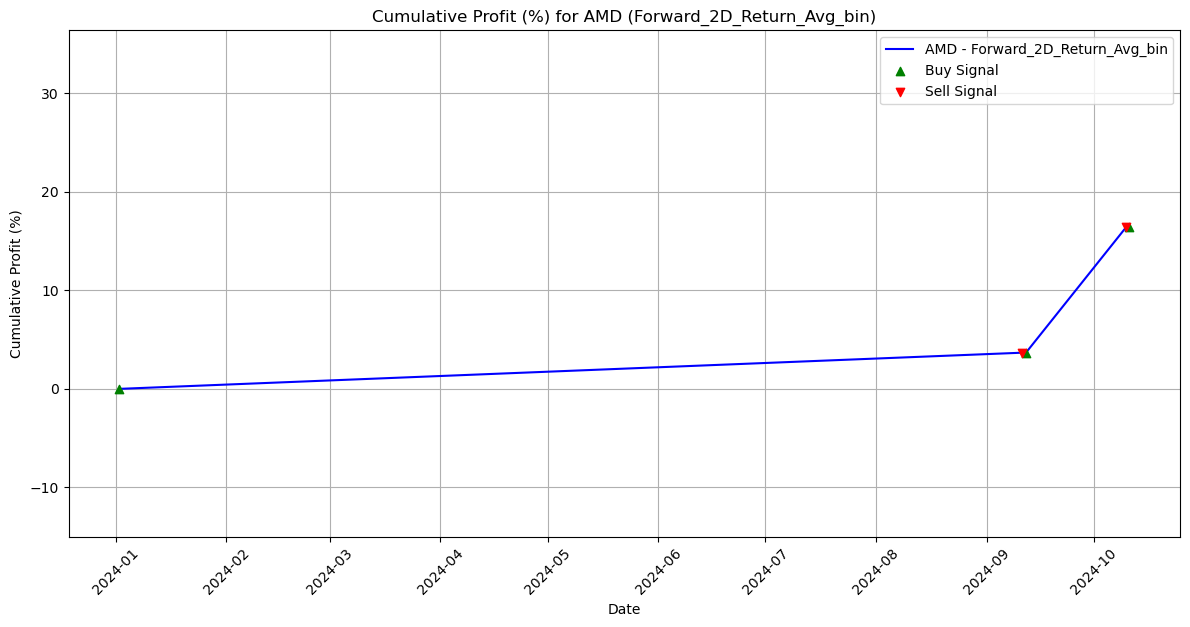

Transaction Steps for AMD (Forward_2D_Return_Avg_bin):
Buy Signal 81: Bought at 140.27 on 2024-01-02
Sell Signal 49: Sold at 145.42 on 2024-09-11
Buy Signal 91: Bought at 149.2 on 2024-09-12
Sell Signal 51: Sold at 167.02 on 2024-10-10
Buy Signal 68: Bought at 166.26 on 2024-10-11
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



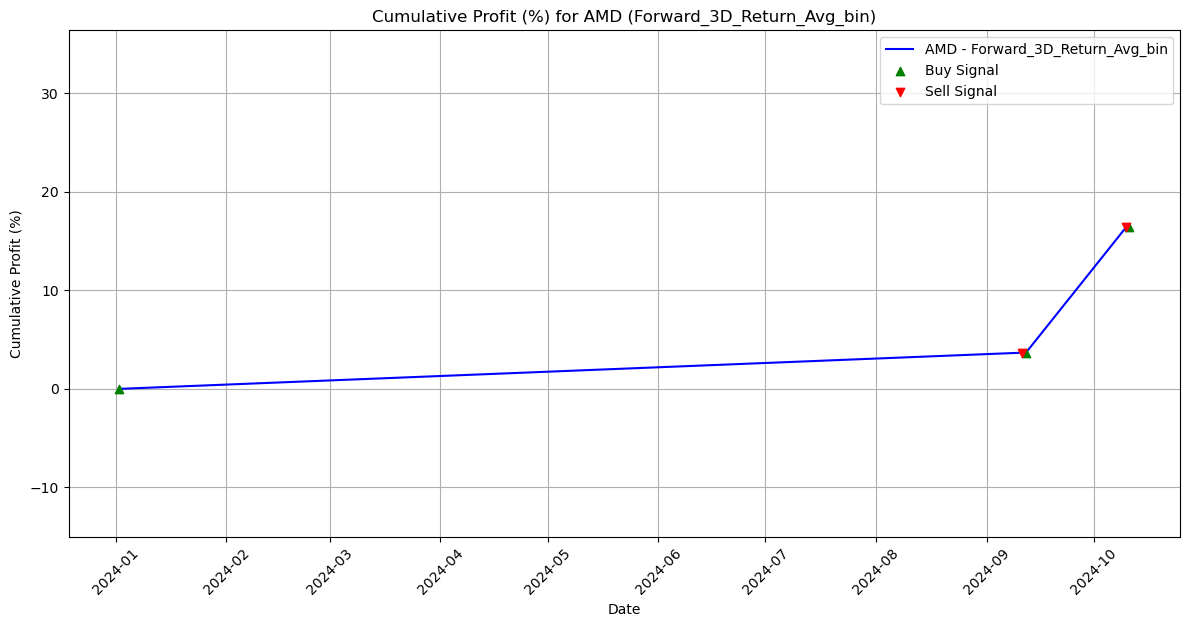

Transaction Steps for AMD (Forward_3D_Return_Avg_bin):
Buy Signal 81: Bought at 140.27 on 2024-01-02
Sell Signal 49: Sold at 145.42 on 2024-09-11
Buy Signal 91: Bought at 149.2 on 2024-09-12
Sell Signal 51: Sold at 167.02 on 2024-10-10
Buy Signal 68: Bought at 166.26 on 2024-10-11
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



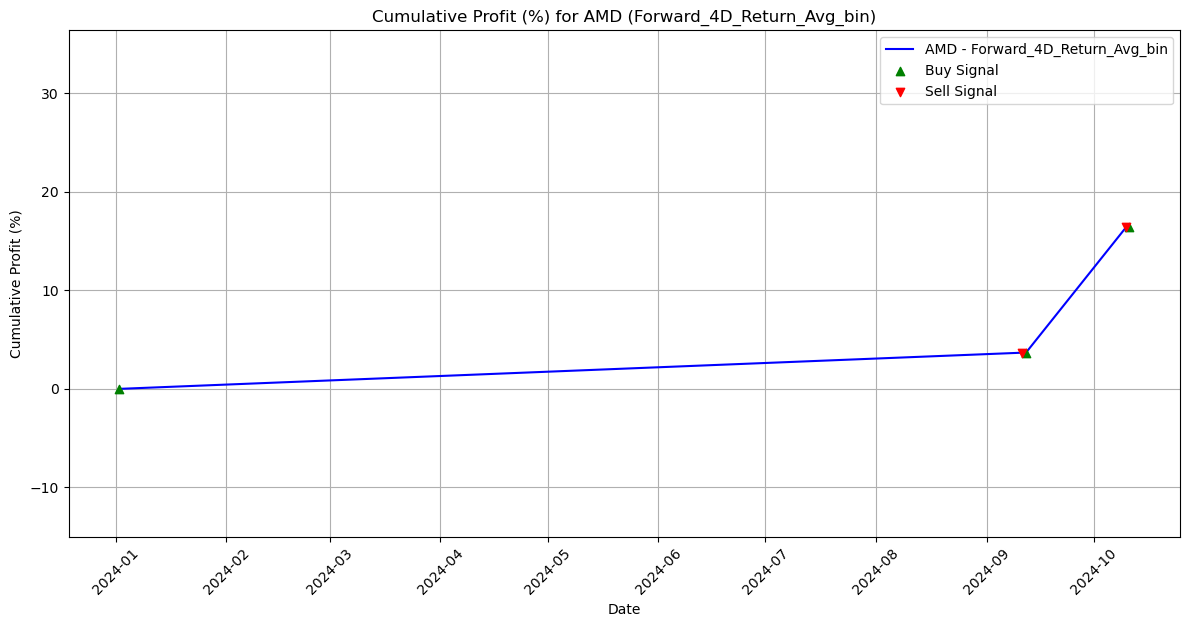

Transaction Steps for AMD (Forward_4D_Return_Avg_bin):
Buy Signal 81: Bought at 140.27 on 2024-01-02
Sell Signal 49: Sold at 145.42 on 2024-09-11
Buy Signal 91: Bought at 149.2 on 2024-09-12
Sell Signal 51: Sold at 167.02 on 2024-10-10
Buy Signal 68: Bought at 166.26 on 2024-10-11
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



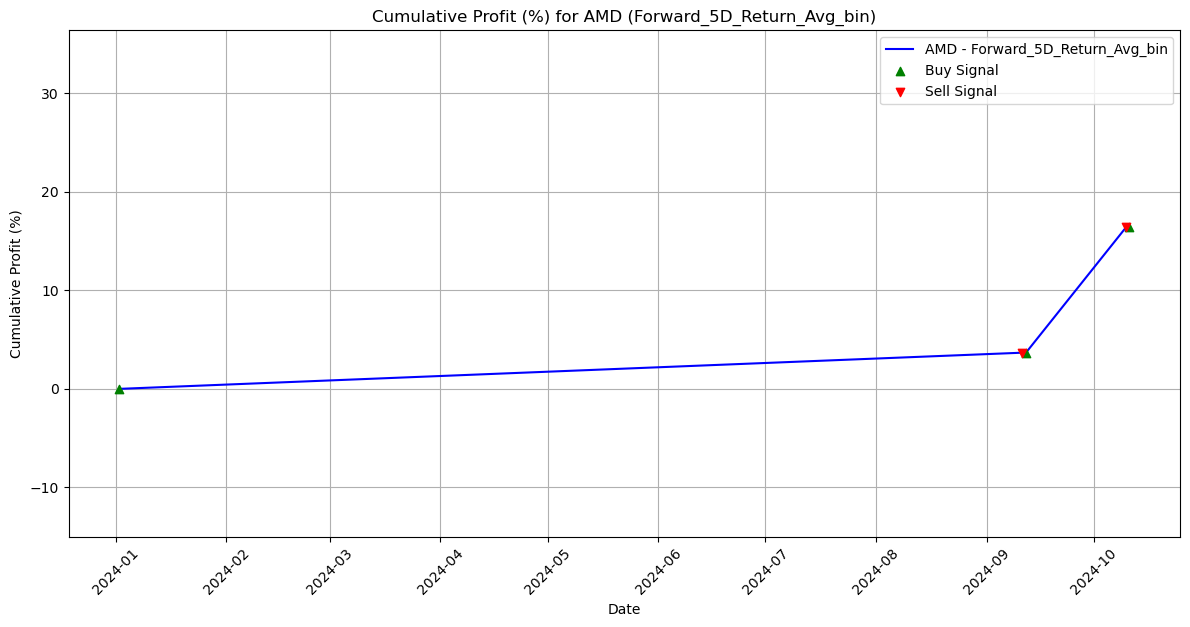

Transaction Steps for AMD (Forward_5D_Return_Avg_bin):
Buy Signal 81: Bought at 140.27 on 2024-01-02
Sell Signal 49: Sold at 145.42 on 2024-09-11
Buy Signal 91: Bought at 149.2 on 2024-09-12
Sell Signal 51: Sold at 167.02 on 2024-10-10
Buy Signal 68: Bought at 166.26 on 2024-10-11
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



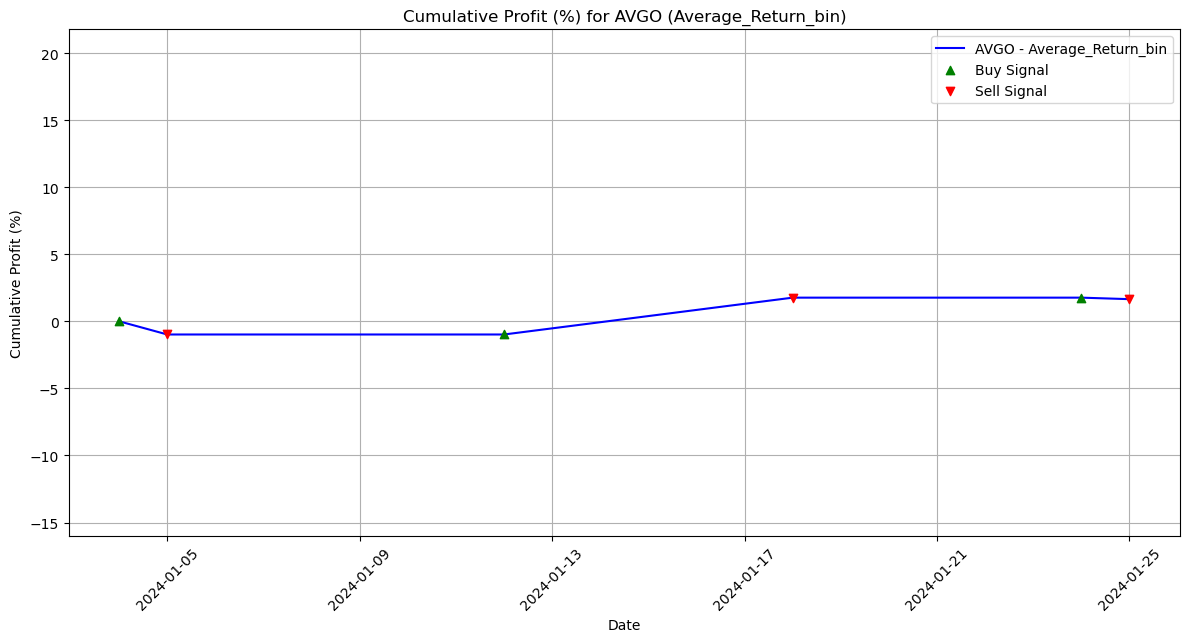

Transaction Steps for AVGO (Average_Return_bin):
Buy Signal 40: Bought at 105.96 on 2024-01-04
Sell Signal 51: Sold at 104.92 on 2024-01-05
Buy Signal 19: Bought at 110.7 on 2024-01-12
Sell Signal 60: Sold at 113.61 on 2024-01-18
Buy Signal 41: Bought at 125.57 on 2024-01-24
Sell Signal 63: Sold at 125.45 on 2024-01-25
Hit Rate: 33.33%
Maximum Drawdown: 0.98%

--------------------------------------------------

No valid data to plot for AVGO - Forward_1D_Return_Avg_bin.


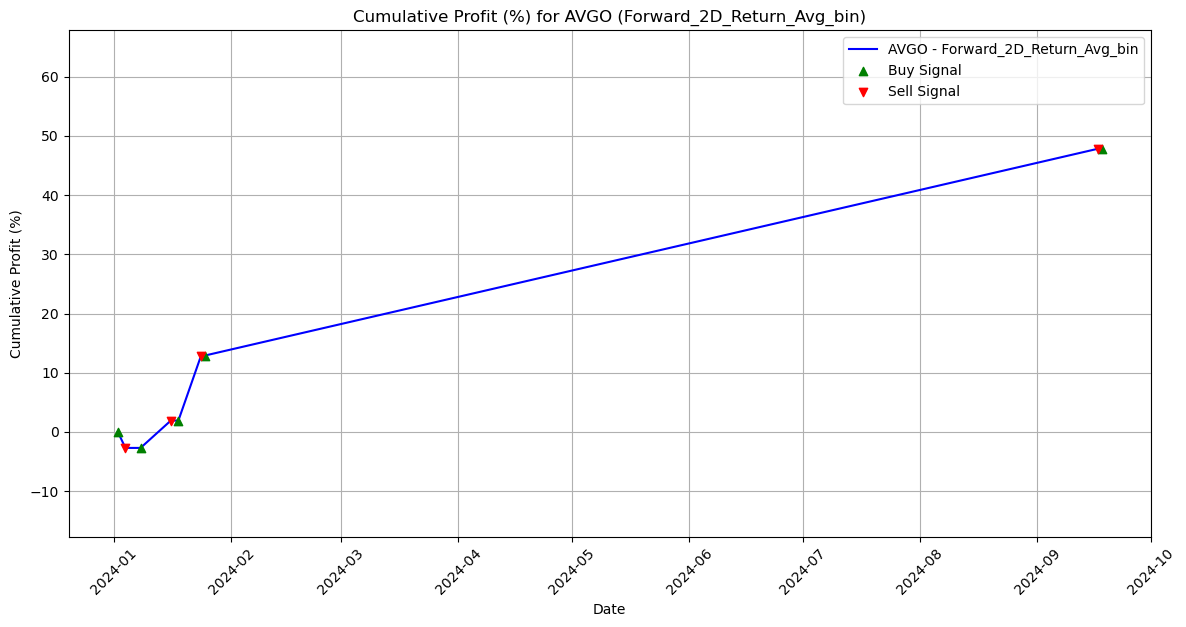

Transaction Steps for AVGO (Forward_2D_Return_Avg_bin):
Buy Signal 63: Bought at 108.9 on 2024-01-02
Sell Signal 40: Sold at 105.96 on 2024-01-04
Buy Signal 62: Bought at 106.7 on 2024-01-08
Sell Signal 42: Sold at 111.73 on 2024-01-16
Buy Signal 60: Bought at 113.61 on 2024-01-18
Sell Signal 41: Sold at 125.57 on 2024-01-24
Buy Signal 63: Bought at 125.45 on 2024-01-25
Sell Signal 57: Sold at 163.49 on 2024-09-17
Buy Signal 81: Bought at 164.56 on 2024-09-18
Hit Rate: 75.00%
Maximum Drawdown: 2.70%

--------------------------------------------------



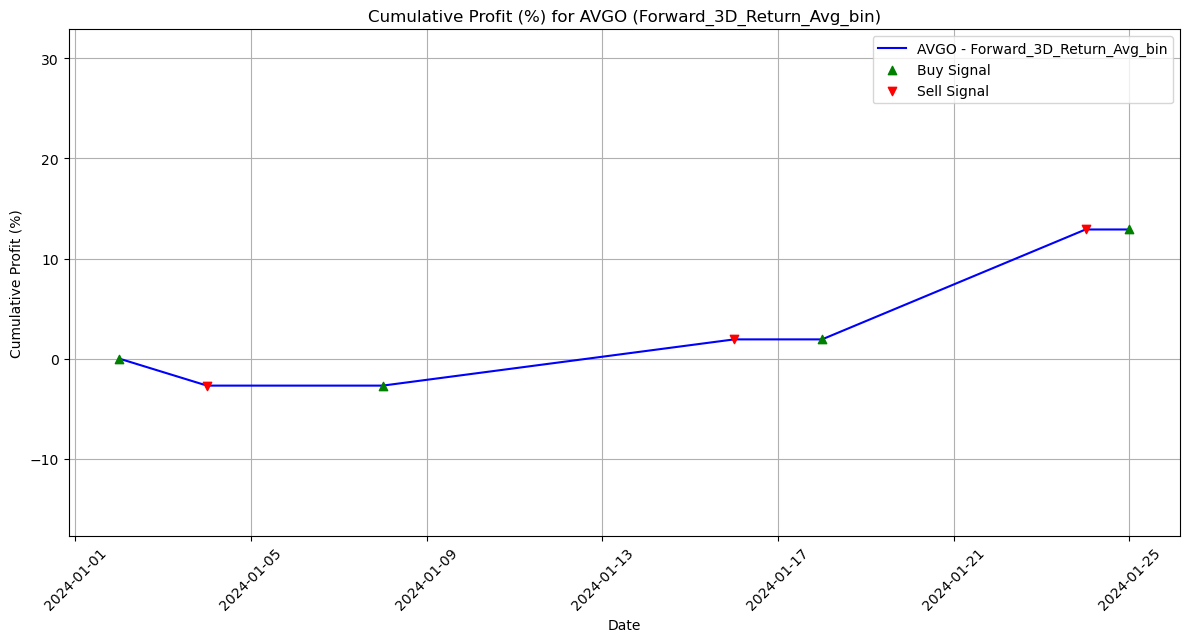

Transaction Steps for AVGO (Forward_3D_Return_Avg_bin):
Buy Signal 63: Bought at 108.9 on 2024-01-02
Sell Signal 40: Sold at 105.96 on 2024-01-04
Buy Signal 62: Bought at 106.7 on 2024-01-08
Sell Signal 42: Sold at 111.73 on 2024-01-16
Buy Signal 60: Bought at 113.61 on 2024-01-18
Sell Signal 41: Sold at 125.57 on 2024-01-24
Buy Signal 63: Bought at 125.45 on 2024-01-25
Hit Rate: 66.67%
Maximum Drawdown: 2.70%

--------------------------------------------------



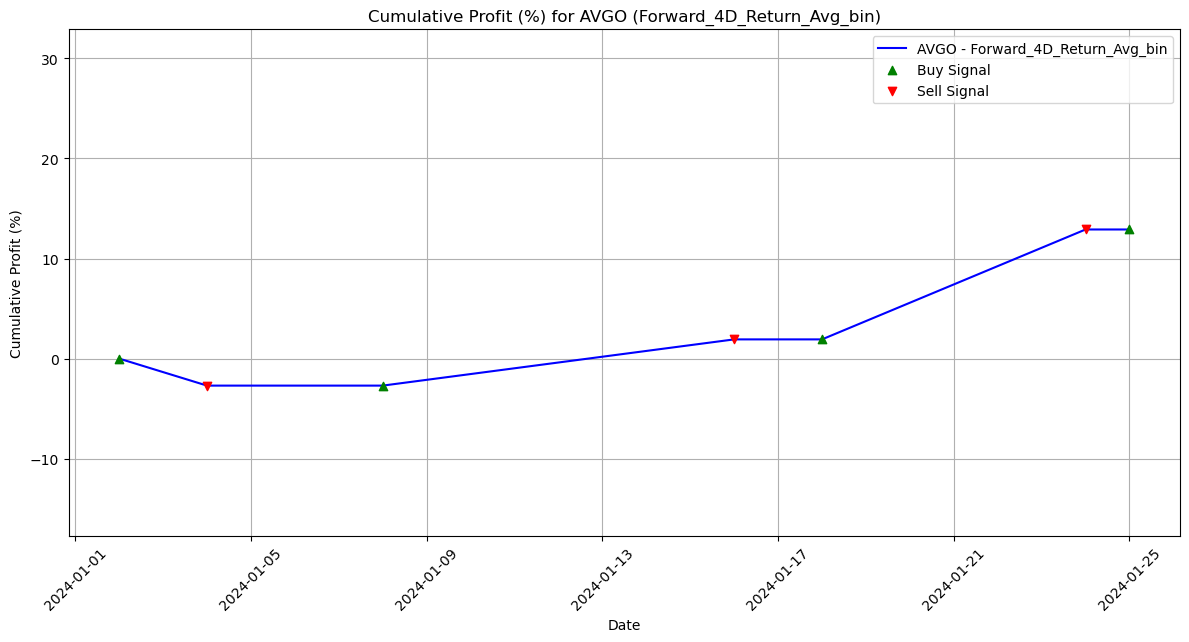

Transaction Steps for AVGO (Forward_4D_Return_Avg_bin):
Buy Signal 63: Bought at 108.9 on 2024-01-02
Sell Signal 40: Sold at 105.96 on 2024-01-04
Buy Signal 62: Bought at 106.7 on 2024-01-08
Sell Signal 42: Sold at 111.73 on 2024-01-16
Buy Signal 60: Bought at 113.61 on 2024-01-18
Sell Signal 41: Sold at 125.57 on 2024-01-24
Buy Signal 63: Bought at 125.45 on 2024-01-25
Hit Rate: 66.67%
Maximum Drawdown: 2.70%

--------------------------------------------------



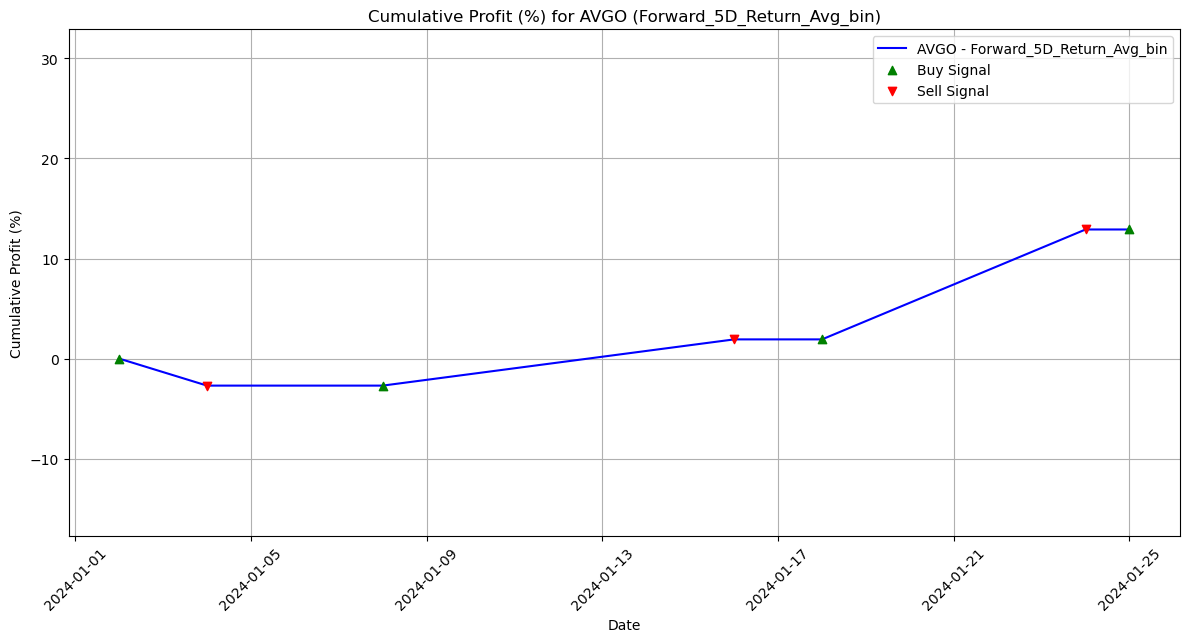

Transaction Steps for AVGO (Forward_5D_Return_Avg_bin):
Buy Signal 63: Bought at 108.9 on 2024-01-02
Sell Signal 40: Sold at 105.96 on 2024-01-04
Buy Signal 62: Bought at 106.7 on 2024-01-08
Sell Signal 42: Sold at 111.73 on 2024-01-16
Buy Signal 60: Bought at 113.61 on 2024-01-18
Sell Signal 41: Sold at 125.57 on 2024-01-24
Buy Signal 63: Bought at 125.45 on 2024-01-25
Hit Rate: 66.67%
Maximum Drawdown: 2.70%

--------------------------------------------------



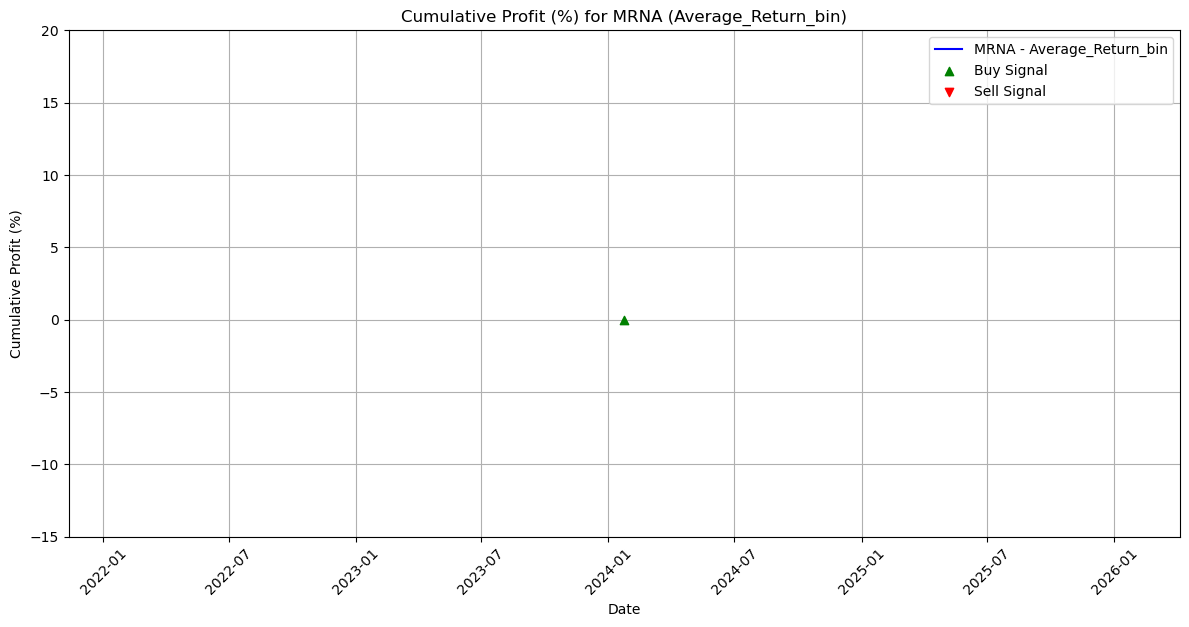

Transaction Steps for MRNA (Average_Return_bin):
Buy Signal 36: Bought at 101.78 on 2024-01-24
Hit Rate: 0.00%
Maximum Drawdown: 0.00%

--------------------------------------------------

No valid data to plot for MRNA - Forward_1D_Return_Avg_bin.


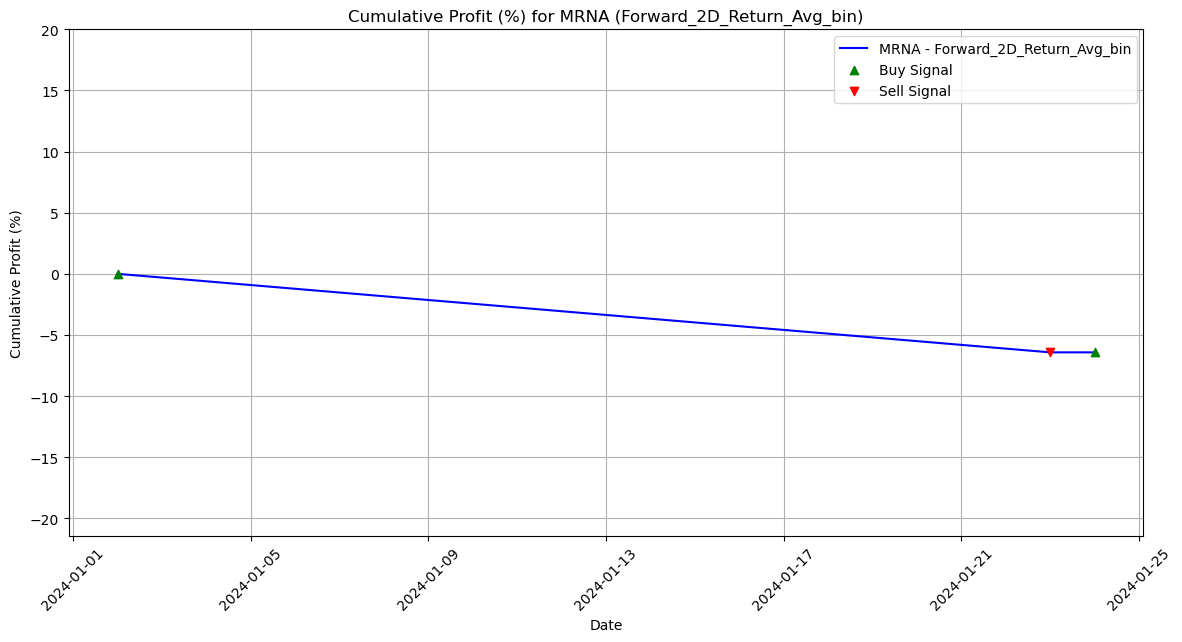

Transaction Steps for MRNA (Forward_2D_Return_Avg_bin):
Buy Signal 70: Bought at 107.87 on 2024-01-02
Sell Signal 122: Sold at 100.94 on 2024-01-23
Buy Signal 36: Bought at 101.78 on 2024-01-24
Hit Rate: 0.00%
Maximum Drawdown: 6.42%

--------------------------------------------------



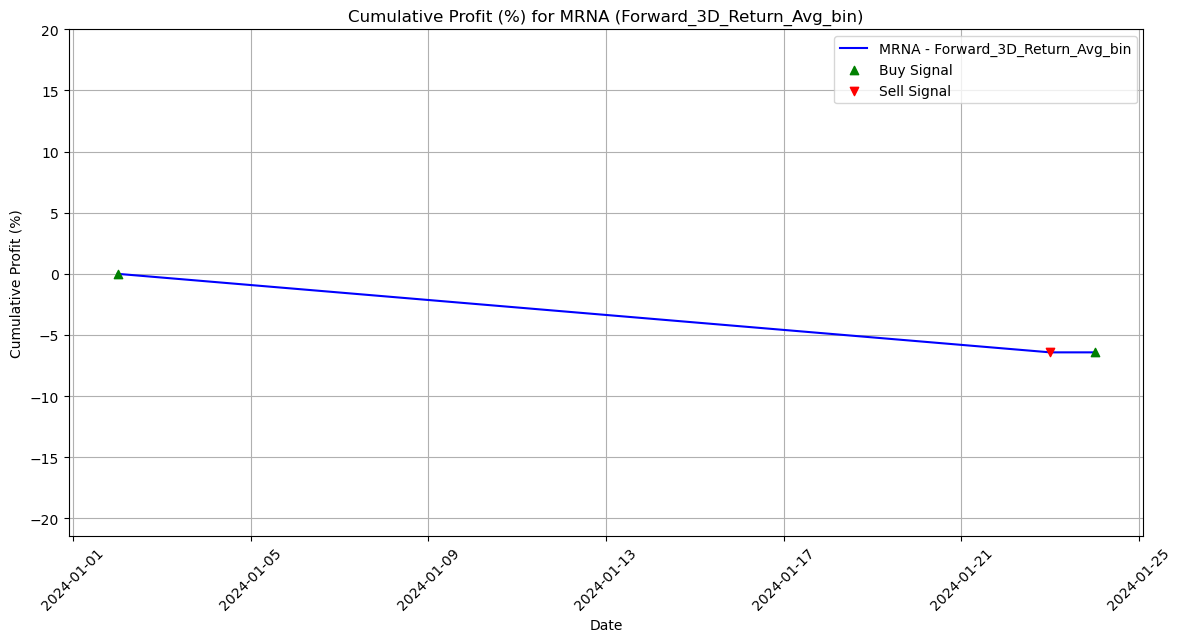

Transaction Steps for MRNA (Forward_3D_Return_Avg_bin):
Buy Signal 70: Bought at 107.87 on 2024-01-02
Sell Signal 122: Sold at 100.94 on 2024-01-23
Buy Signal 36: Bought at 101.78 on 2024-01-24
Hit Rate: 0.00%
Maximum Drawdown: 6.42%

--------------------------------------------------



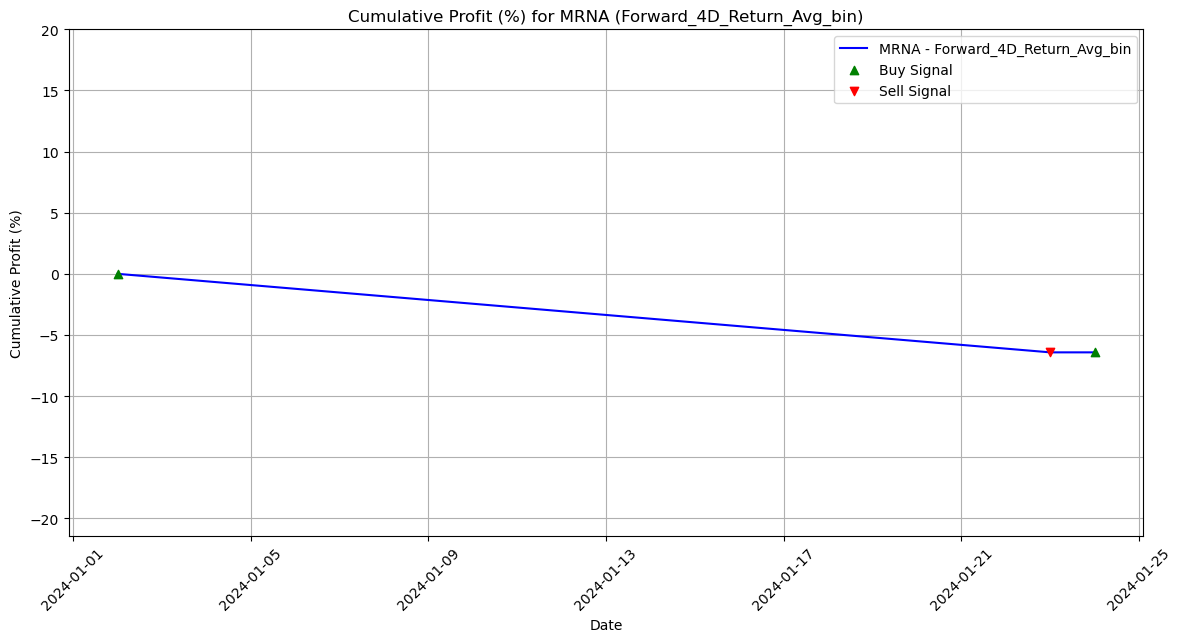

Transaction Steps for MRNA (Forward_4D_Return_Avg_bin):
Buy Signal 70: Bought at 107.87 on 2024-01-02
Sell Signal 122: Sold at 100.94 on 2024-01-23
Buy Signal 36: Bought at 101.78 on 2024-01-24
Hit Rate: 0.00%
Maximum Drawdown: 6.42%

--------------------------------------------------



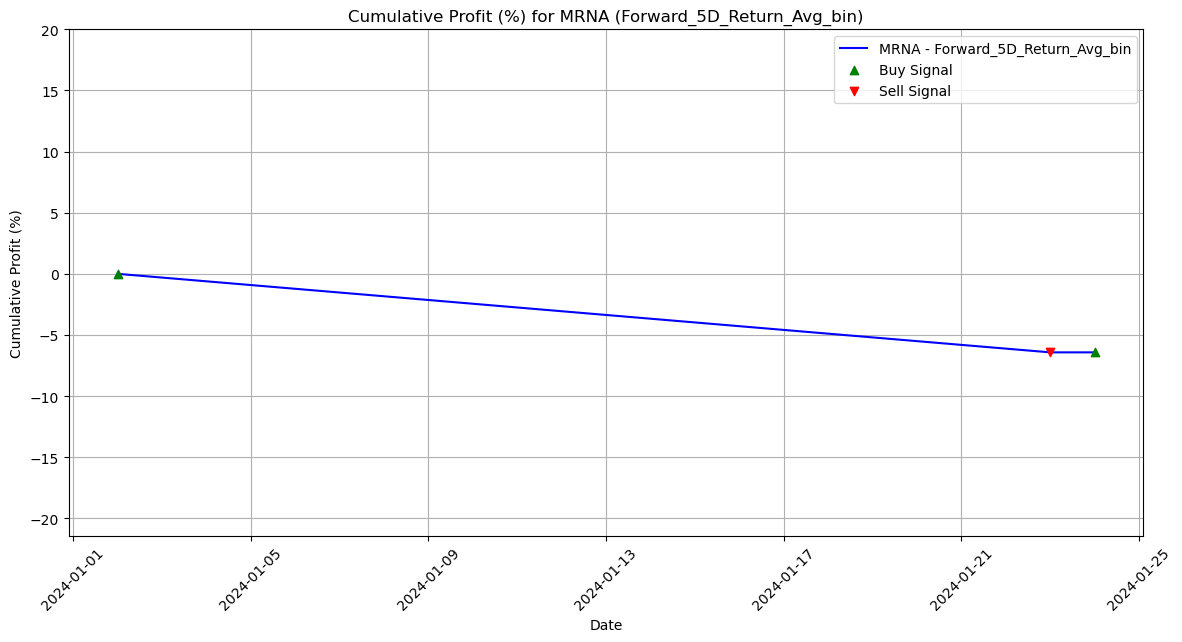

Transaction Steps for MRNA (Forward_5D_Return_Avg_bin):
Buy Signal 70: Bought at 107.87 on 2024-01-02
Sell Signal 122: Sold at 100.94 on 2024-01-23
Buy Signal 36: Bought at 101.78 on 2024-01-24
Hit Rate: 0.00%
Maximum Drawdown: 6.42%

--------------------------------------------------



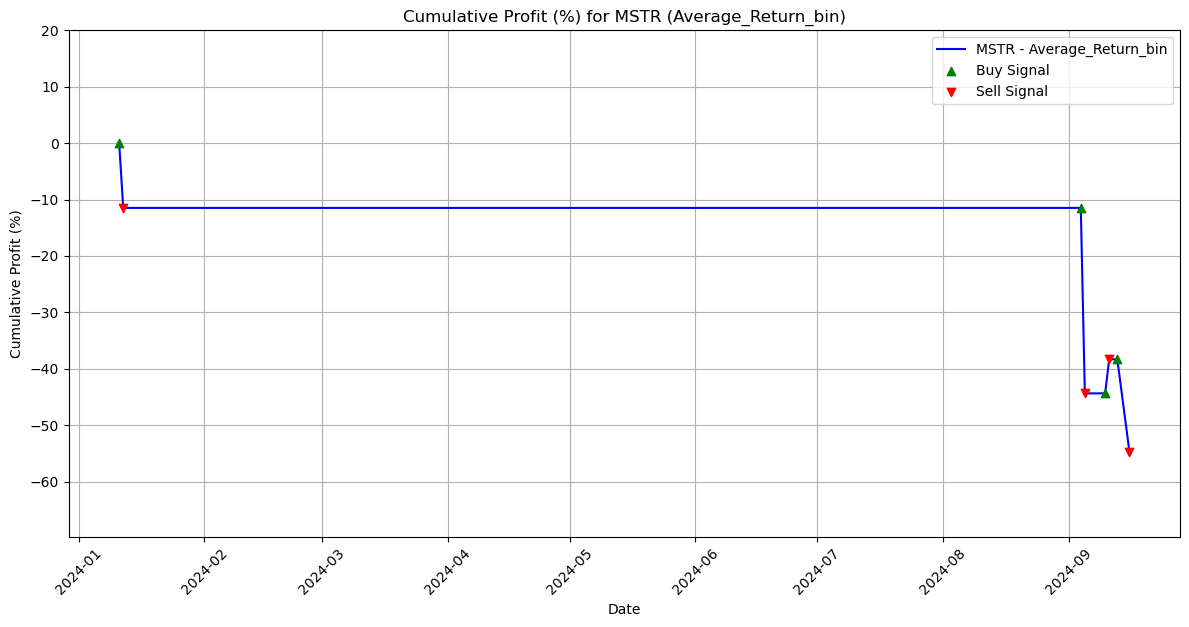

Transaction Steps for MSTR (Average_Return_bin):
Buy Signal 50: Bought at 57.11 on 2024-01-11
Sell Signal 97: Sold at 50.55 on 2024-01-12
Buy Signal 49: Bought at 1241.18 on 2024-09-04
Sell Signal 90: Sold at 1222.4 on 2024-09-05
Buy Signal 39: Bought at 1256.55 on 2024-09-10
Sell Signal 57: Sold at 1260.0 on 2024-09-11
Buy Signal 50: Bought at 1364.35 on 2024-09-13
Sell Signal 72: Sold at 1354.95 on 2024-09-16
Hit Rate: 25.00%
Maximum Drawdown: 54.79%

--------------------------------------------------

No valid data to plot for MSTR - Forward_1D_Return_Avg_bin.


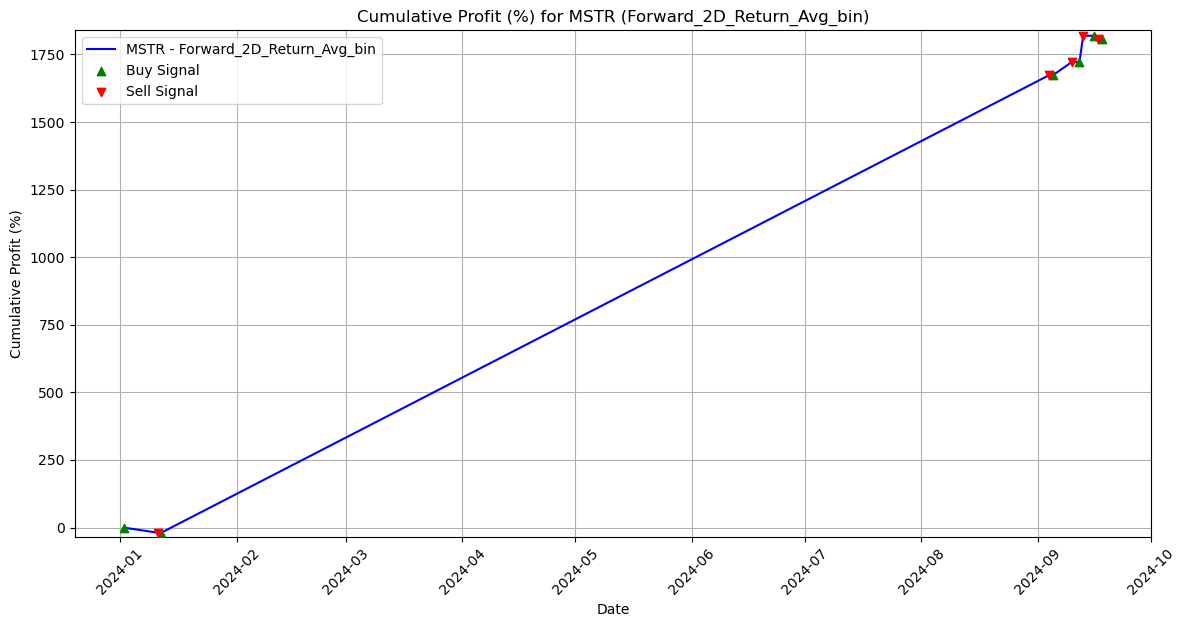

Transaction Steps for MSTR (Forward_2D_Return_Avg_bin):
Buy Signal 100: Bought at 70.35 on 2024-01-02
Sell Signal 50: Sold at 57.11 on 2024-01-11
Buy Signal 97: Bought at 50.55 on 2024-01-12
Sell Signal 49: Sold at 1241.18 on 2024-09-04
Buy Signal 90: Bought at 1222.4 on 2024-09-05
Sell Signal 39: Sold at 1256.55 on 2024-09-10
Buy Signal 94: Bought at 1296.2 on 2024-09-12
Sell Signal 50: Sold at 1364.35 on 2024-09-13
Buy Signal 72: Bought at 1354.95 on 2024-09-16
Sell Signal 47: Sold at 1346.72 on 2024-09-17
Buy Signal 80: Bought at 1337.75 on 2024-09-18
Hit Rate: 60.00%
Maximum Drawdown: 18.82%

--------------------------------------------------



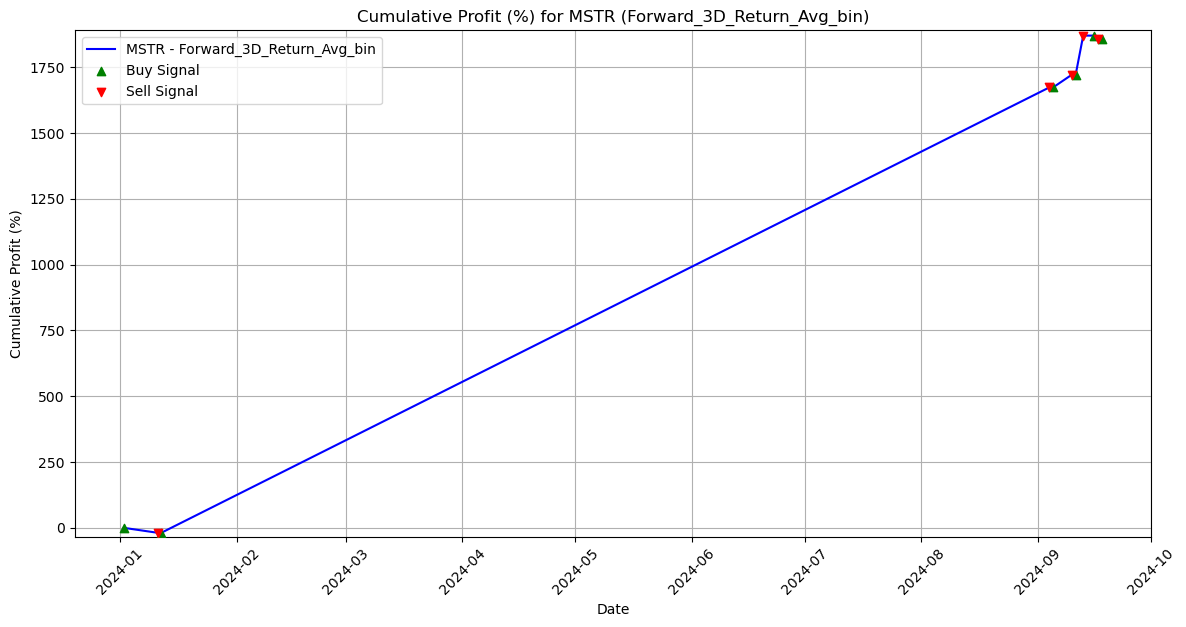

Transaction Steps for MSTR (Forward_3D_Return_Avg_bin):
Buy Signal 100: Bought at 70.35 on 2024-01-02
Sell Signal 50: Sold at 57.11 on 2024-01-11
Buy Signal 97: Bought at 50.55 on 2024-01-12
Sell Signal 49: Sold at 1241.18 on 2024-09-04
Buy Signal 90: Bought at 1222.4 on 2024-09-05
Sell Signal 39: Sold at 1256.55 on 2024-09-10
Buy Signal 57: Bought at 1260.0 on 2024-09-11
Sell Signal 50: Sold at 1364.35 on 2024-09-13
Buy Signal 72: Bought at 1354.95 on 2024-09-16
Sell Signal 47: Sold at 1346.72 on 2024-09-17
Buy Signal 80: Bought at 1337.75 on 2024-09-18
Hit Rate: 60.00%
Maximum Drawdown: 18.82%

--------------------------------------------------



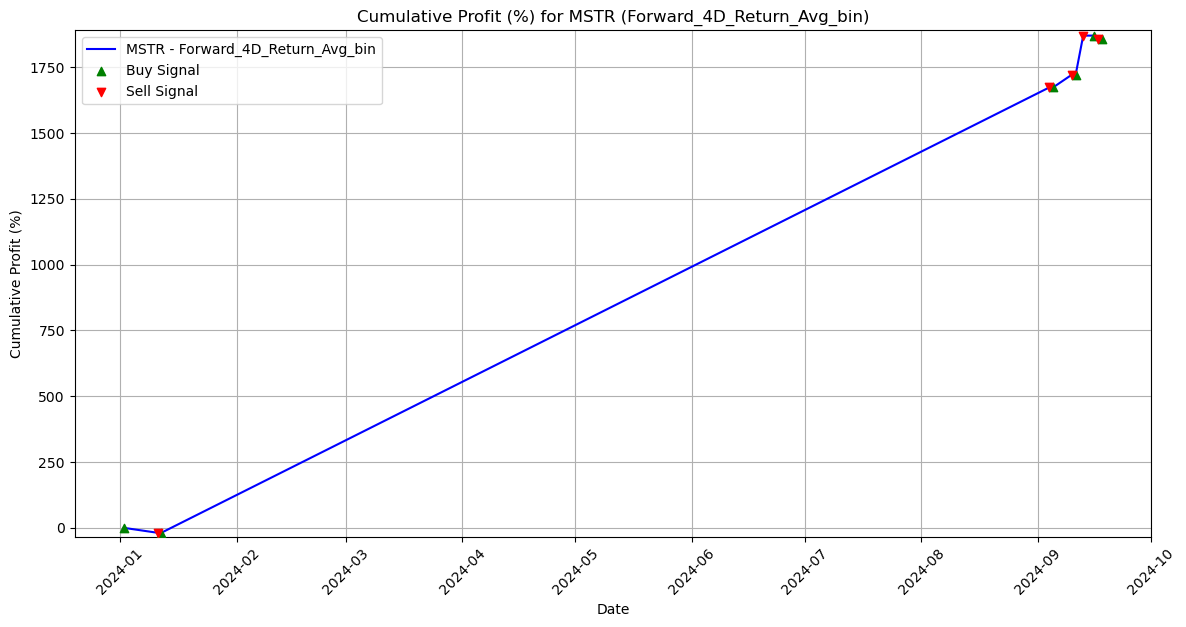

Transaction Steps for MSTR (Forward_4D_Return_Avg_bin):
Buy Signal 100: Bought at 70.35 on 2024-01-02
Sell Signal 50: Sold at 57.11 on 2024-01-11
Buy Signal 97: Bought at 50.55 on 2024-01-12
Sell Signal 49: Sold at 1241.18 on 2024-09-04
Buy Signal 90: Bought at 1222.4 on 2024-09-05
Sell Signal 39: Sold at 1256.55 on 2024-09-10
Buy Signal 57: Bought at 1260.0 on 2024-09-11
Sell Signal 50: Sold at 1364.35 on 2024-09-13
Buy Signal 72: Bought at 1354.95 on 2024-09-16
Sell Signal 47: Sold at 1346.72 on 2024-09-17
Buy Signal 80: Bought at 1337.75 on 2024-09-18
Hit Rate: 60.00%
Maximum Drawdown: 18.82%

--------------------------------------------------



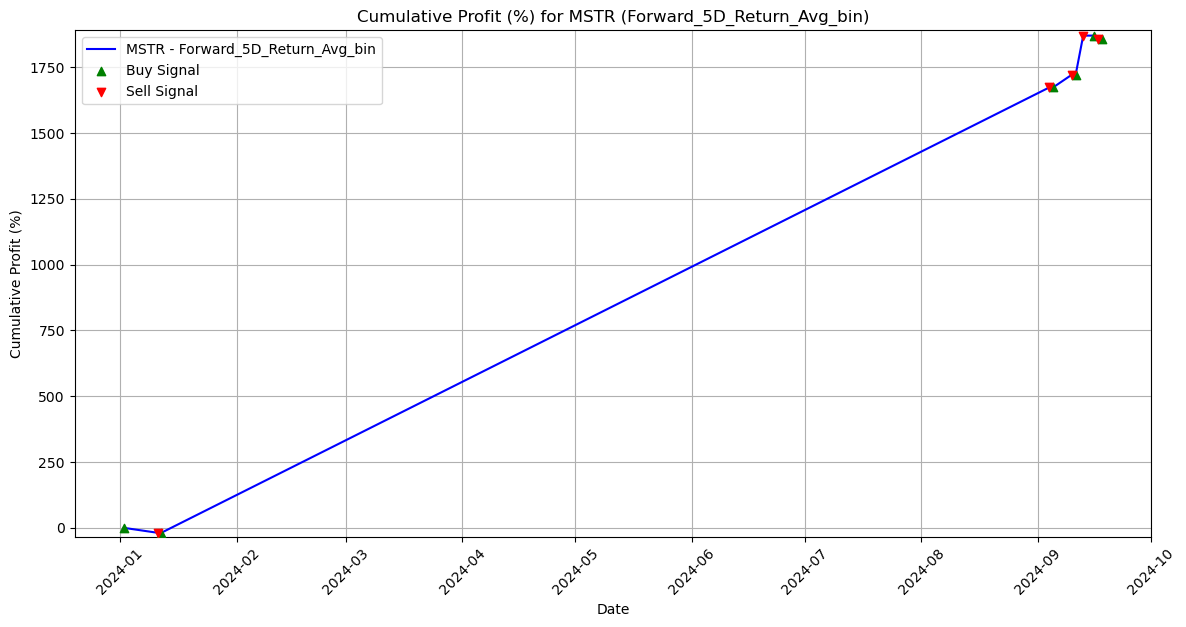

Transaction Steps for MSTR (Forward_5D_Return_Avg_bin):
Buy Signal 100: Bought at 70.35 on 2024-01-02
Sell Signal 50: Sold at 57.11 on 2024-01-11
Buy Signal 97: Bought at 50.55 on 2024-01-12
Sell Signal 49: Sold at 1241.18 on 2024-09-04
Buy Signal 90: Bought at 1222.4 on 2024-09-05
Sell Signal 39: Sold at 1256.55 on 2024-09-10
Buy Signal 57: Bought at 1260.0 on 2024-09-11
Sell Signal 50: Sold at 1364.35 on 2024-09-13
Buy Signal 72: Bought at 1354.95 on 2024-09-16
Sell Signal 47: Sold at 1346.72 on 2024-09-17
Buy Signal 80: Bought at 1337.75 on 2024-09-18
Hit Rate: 60.00%
Maximum Drawdown: 18.82%

--------------------------------------------------

No valid data to plot for ROKU - Average_Return_bin.
No valid data to plot for ROKU - Forward_1D_Return_Avg_bin.


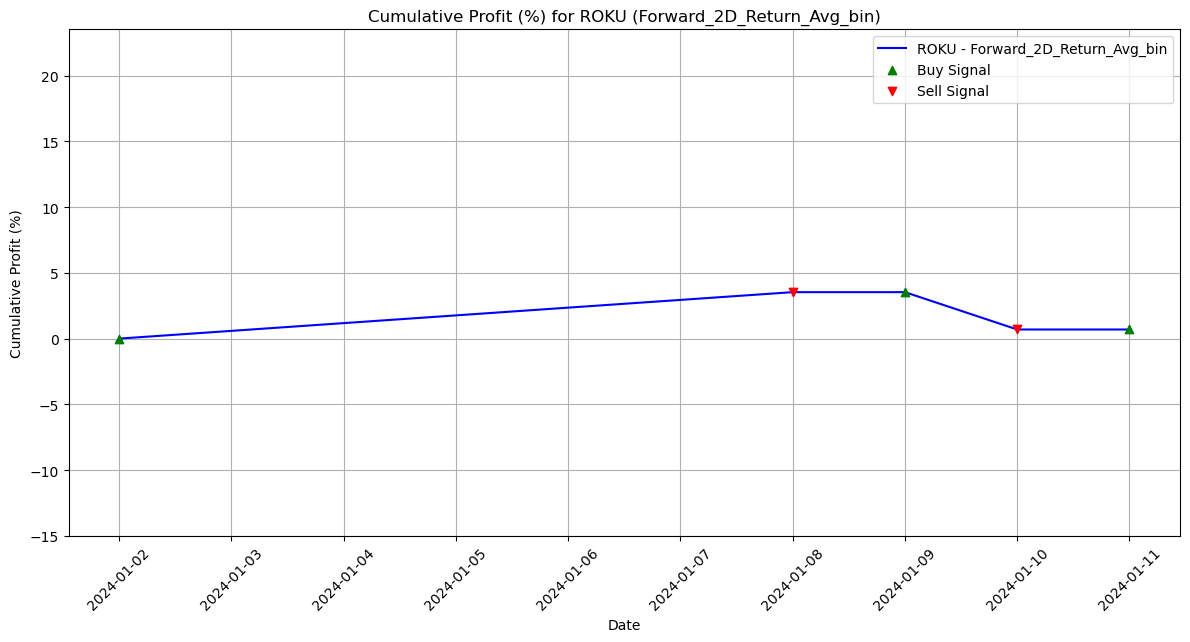

Transaction Steps for ROKU (Forward_2D_Return_Avg_bin):
Buy Signal 89: Bought at 89.4 on 2024-01-02
Sell Signal 105: Sold at 92.56 on 2024-01-08
Buy Signal 73: Bought at 92.41 on 2024-01-09
Sell Signal 105: Sold at 89.87 on 2024-01-10
Buy Signal 90: Bought at 87.67 on 2024-01-11
Hit Rate: 50.00%
Maximum Drawdown: 2.84%

--------------------------------------------------



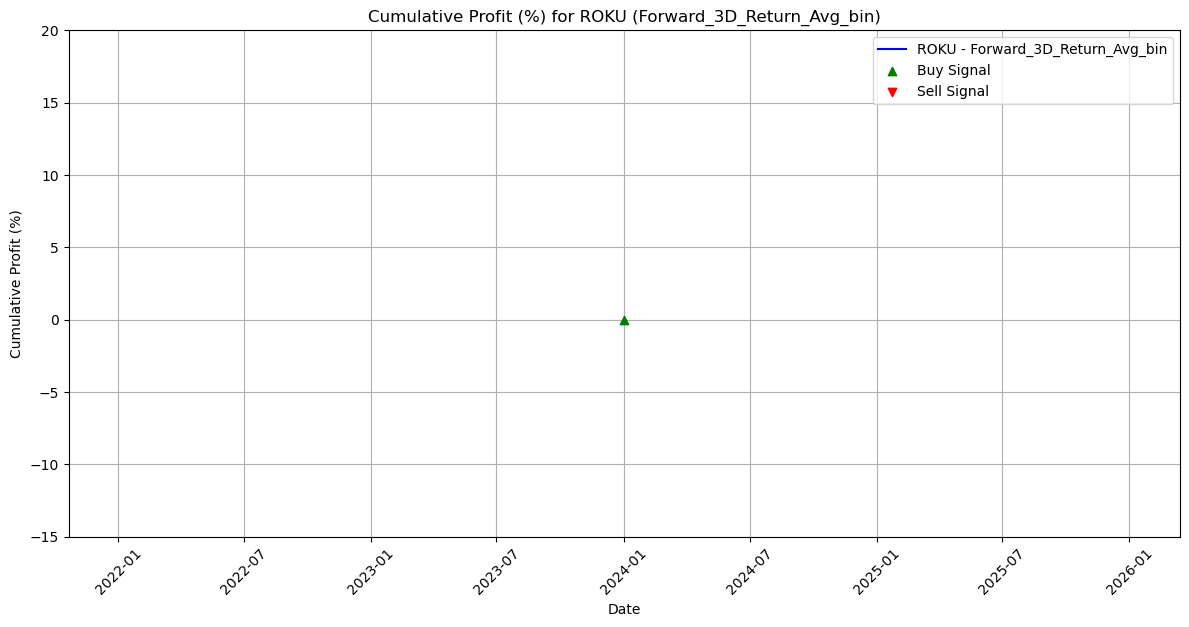

Transaction Steps for ROKU (Forward_3D_Return_Avg_bin):
Buy Signal 89: Bought at 89.4 on 2024-01-02
Hit Rate: 0.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



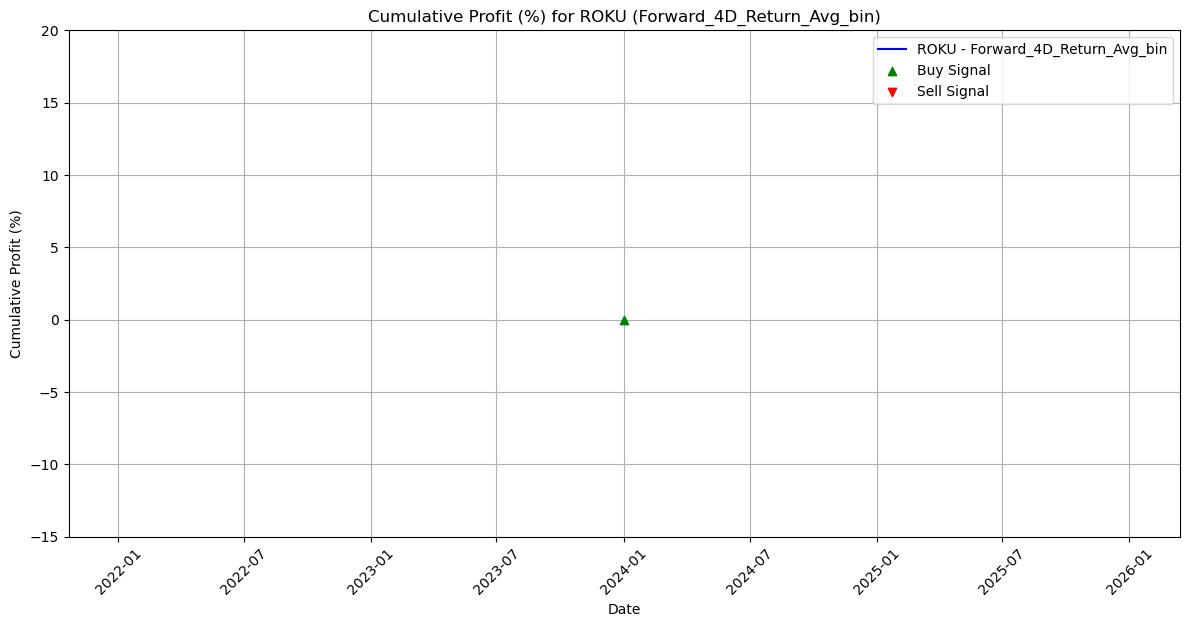

Transaction Steps for ROKU (Forward_4D_Return_Avg_bin):
Buy Signal 89: Bought at 89.4 on 2024-01-02
Hit Rate: 0.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



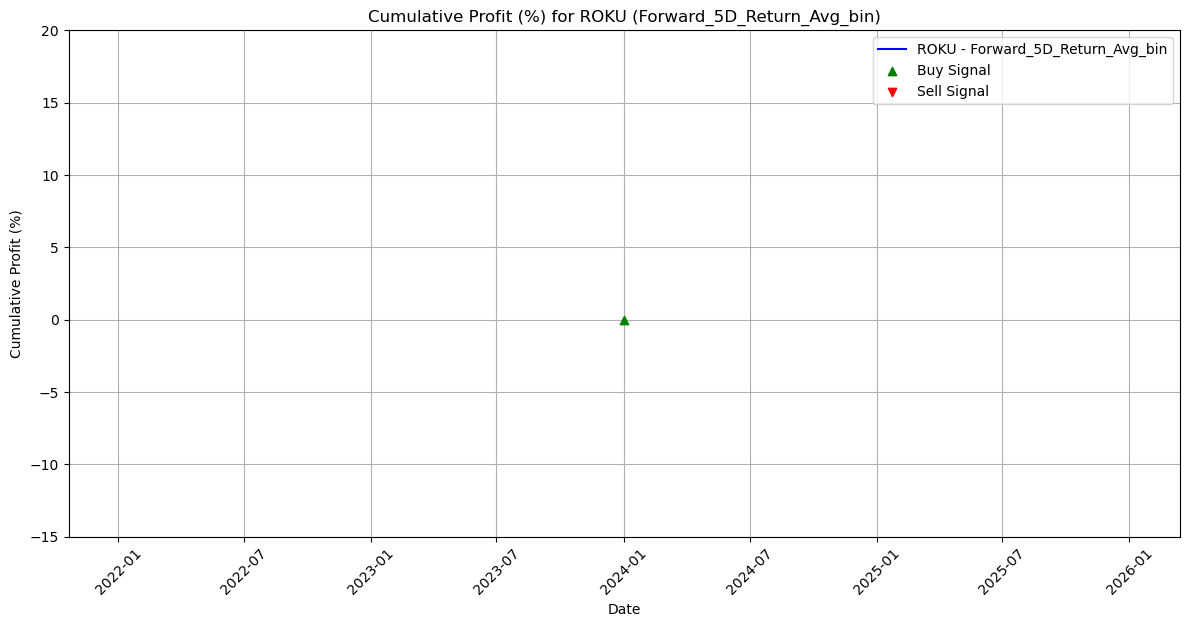

Transaction Steps for ROKU (Forward_5D_Return_Avg_bin):
Buy Signal 89: Bought at 89.4 on 2024-01-02
Hit Rate: 0.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



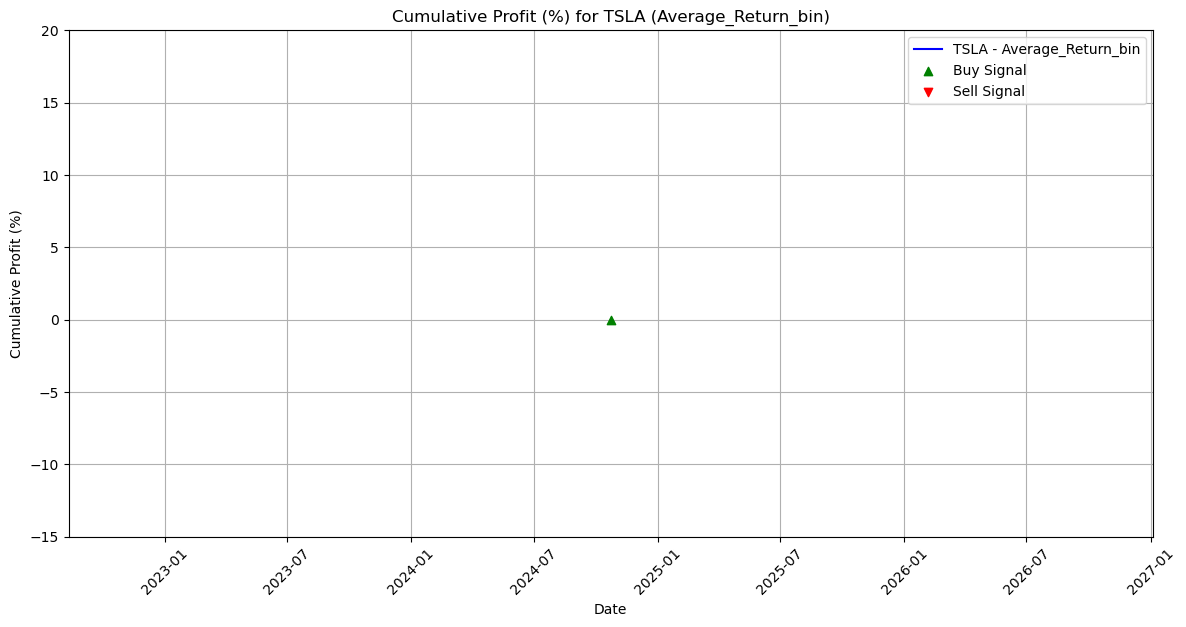

Transaction Steps for TSLA (Average_Return_bin):
Buy Signal 36: Bought at 215.04 on 2024-10-23
Hit Rate: 0.00%
Maximum Drawdown: 0.00%

--------------------------------------------------

No valid data to plot for TSLA - Forward_1D_Return_Avg_bin.


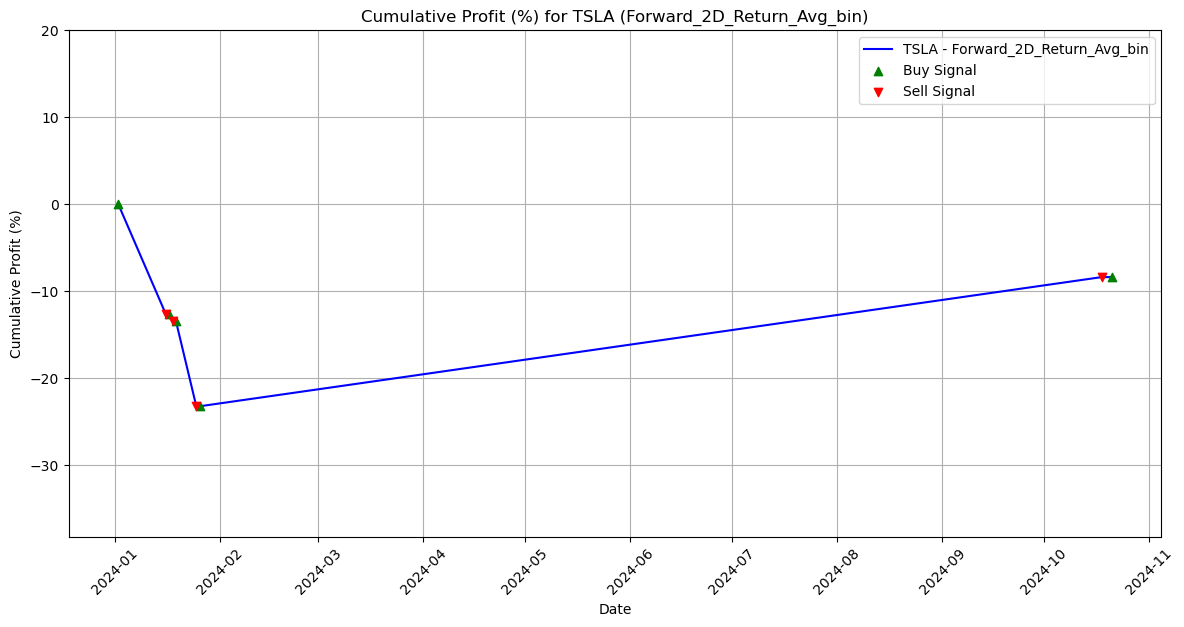

Transaction Steps for TSLA (Forward_2D_Return_Avg_bin):
Buy Signal 65: Bought at 248.07 on 2024-01-02
Sell Signal 48: Sold at 216.76 on 2024-01-16
Buy Signal 66: Bought at 214.56 on 2024-01-17
Sell Signal 57: Sold at 212.52 on 2024-01-18
Buy Signal 86: Bought at 210.46 on 2024-01-19
Sell Signal 52: Sold at 186.19 on 2024-01-25
Buy Signal 70: Bought at 183.92 on 2024-01-26
Sell Signal 47: Sold at 220.76 on 2024-10-18
Buy Signal 69: Bought at 218.51 on 2024-10-21
Hit Rate: 25.00%
Maximum Drawdown: 23.23%

--------------------------------------------------



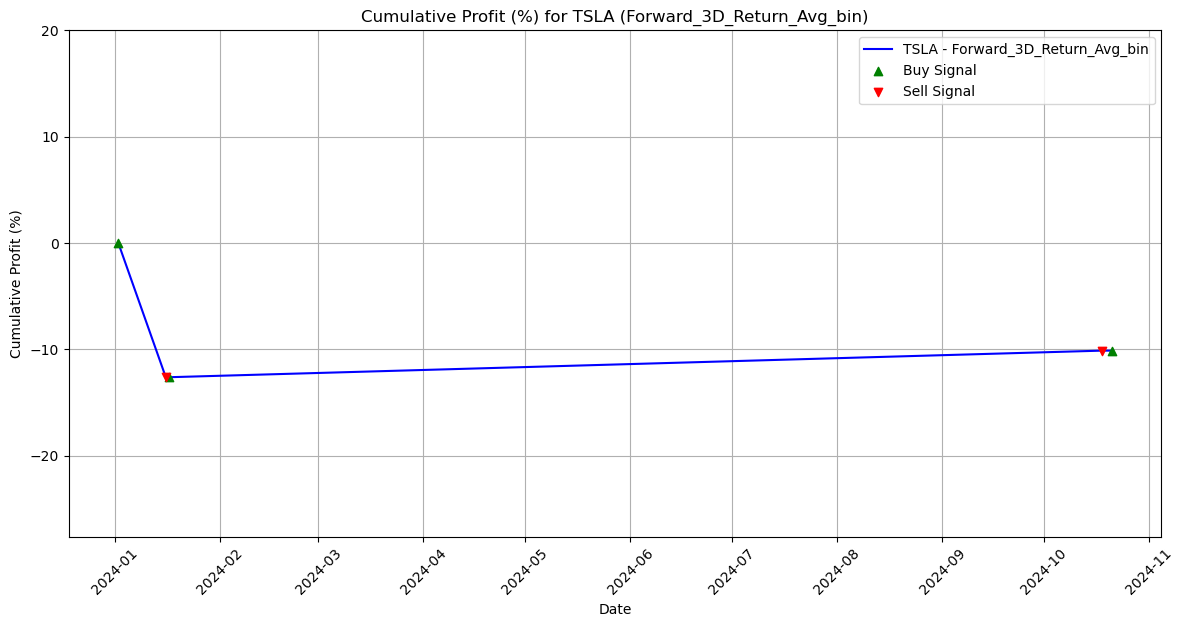

Transaction Steps for TSLA (Forward_3D_Return_Avg_bin):
Buy Signal 65: Bought at 248.07 on 2024-01-02
Sell Signal 48: Sold at 216.76 on 2024-01-16
Buy Signal 66: Bought at 214.56 on 2024-01-17
Sell Signal 47: Sold at 220.76 on 2024-10-18
Buy Signal 69: Bought at 218.51 on 2024-10-21
Hit Rate: 50.00%
Maximum Drawdown: 12.62%

--------------------------------------------------



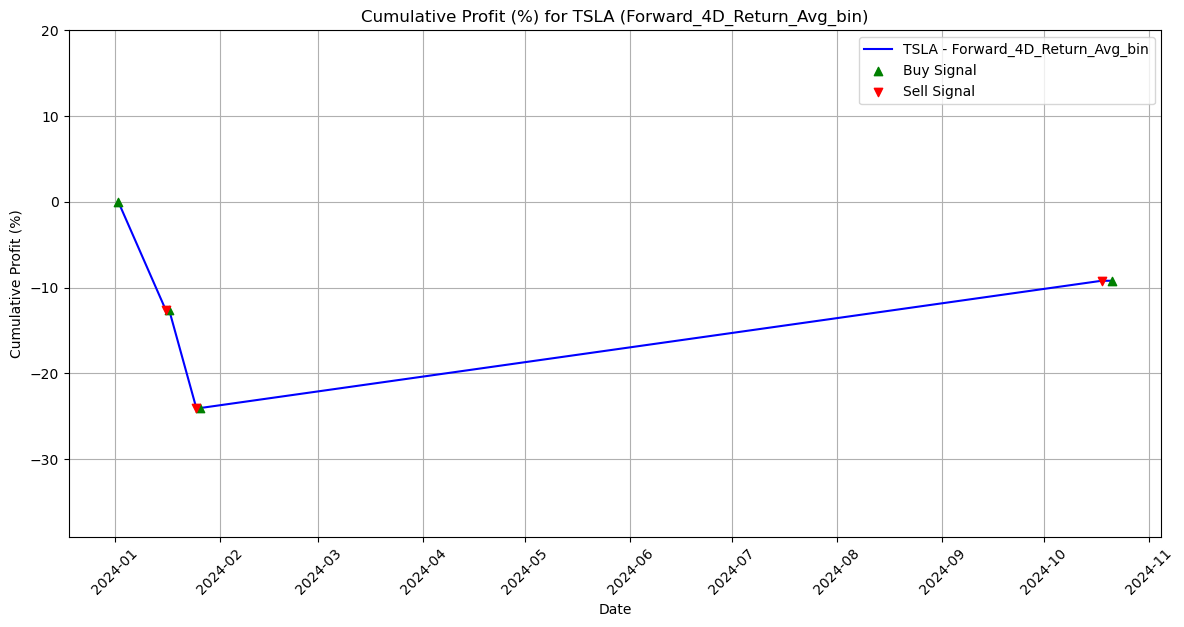

Transaction Steps for TSLA (Forward_4D_Return_Avg_bin):
Buy Signal 65: Bought at 248.07 on 2024-01-02
Sell Signal 48: Sold at 216.76 on 2024-01-16
Buy Signal 66: Bought at 214.56 on 2024-01-17
Sell Signal 52: Sold at 186.19 on 2024-01-25
Buy Signal 70: Bought at 183.92 on 2024-01-26
Sell Signal 47: Sold at 220.76 on 2024-10-18
Buy Signal 69: Bought at 218.51 on 2024-10-21
Hit Rate: 33.33%
Maximum Drawdown: 24.06%

--------------------------------------------------



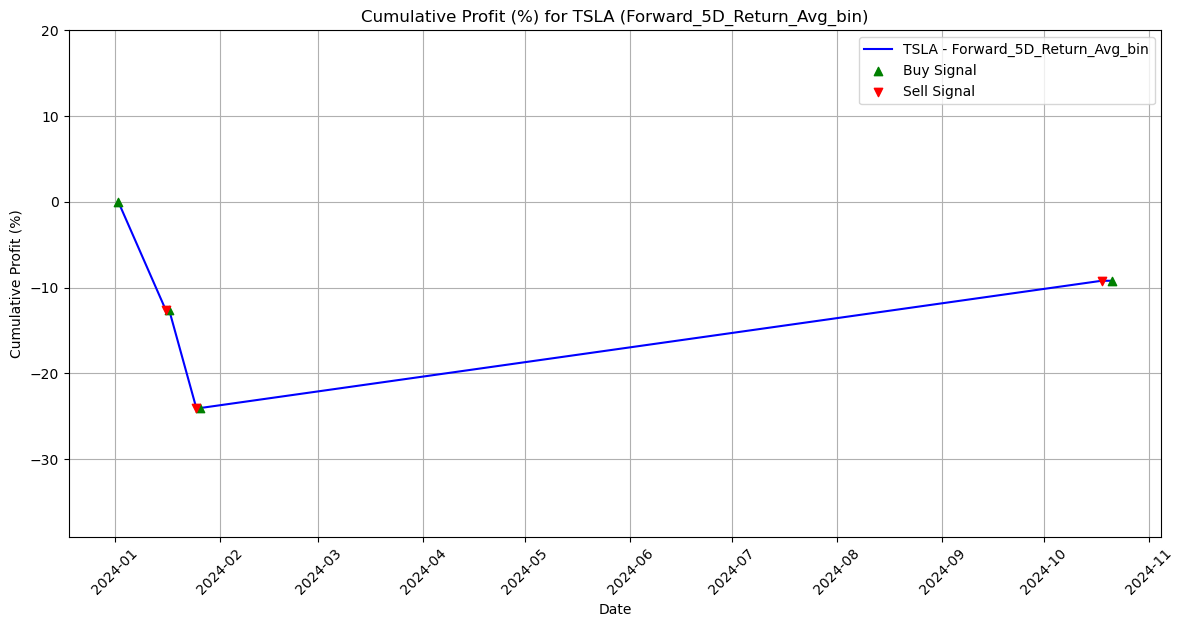

Transaction Steps for TSLA (Forward_5D_Return_Avg_bin):
Buy Signal 65: Bought at 248.07 on 2024-01-02
Sell Signal 48: Sold at 216.76 on 2024-01-16
Buy Signal 66: Bought at 214.56 on 2024-01-17
Sell Signal 52: Sold at 186.19 on 2024-01-25
Buy Signal 70: Bought at 183.92 on 2024-01-26
Sell Signal 47: Sold at 220.76 on 2024-10-18
Buy Signal 69: Bought at 218.51 on 2024-10-21
Hit Rate: 33.33%
Maximum Drawdown: 24.06%

--------------------------------------------------

No valid data to plot for SMCI - Average_Return_bin.
No valid data to plot for SMCI - Forward_1D_Return_Avg_bin.


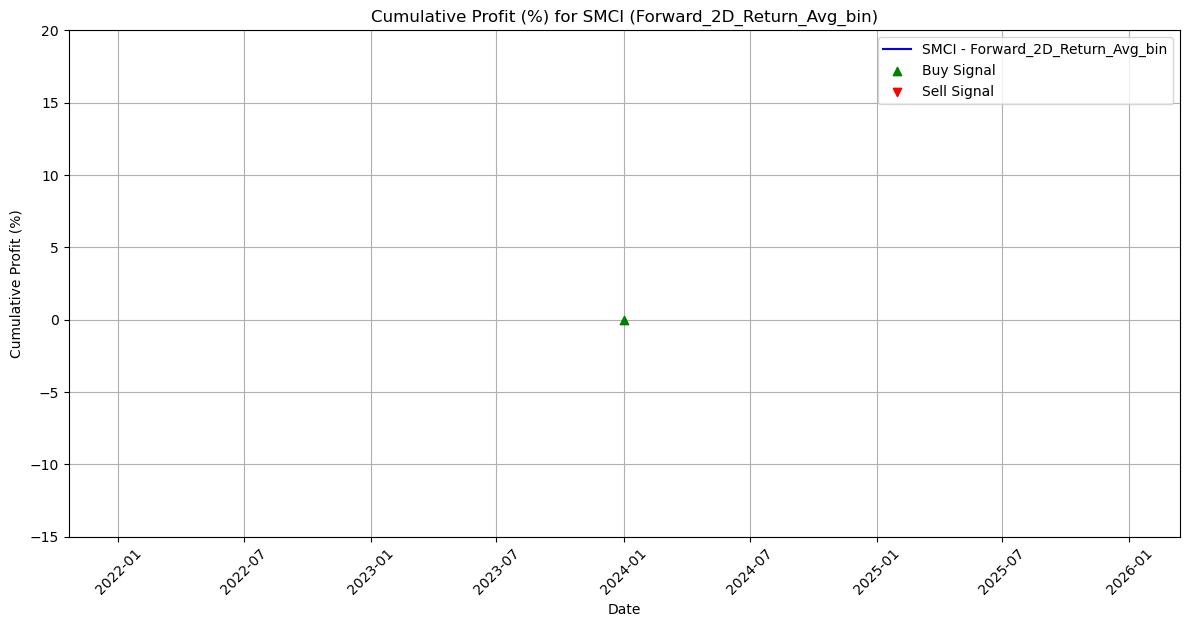

Transaction Steps for SMCI (Forward_2D_Return_Avg_bin):
Buy Signal 84: Bought at 283.3 on 2024-01-02
Hit Rate: 0.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



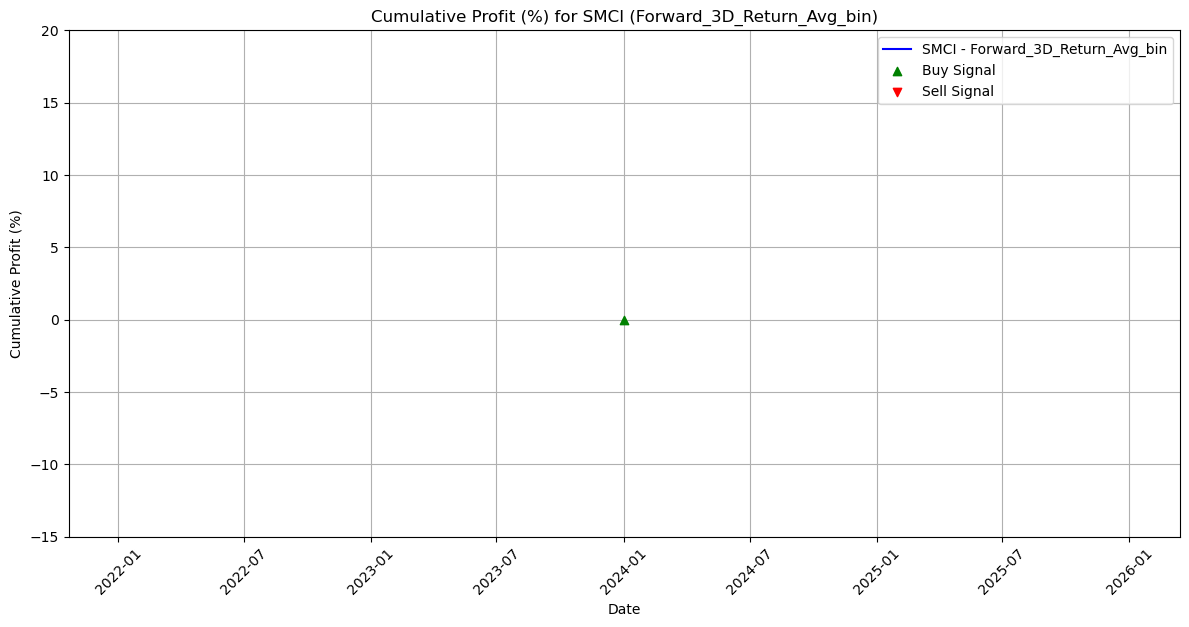

Transaction Steps for SMCI (Forward_3D_Return_Avg_bin):
Buy Signal 84: Bought at 283.3 on 2024-01-02
Hit Rate: 0.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



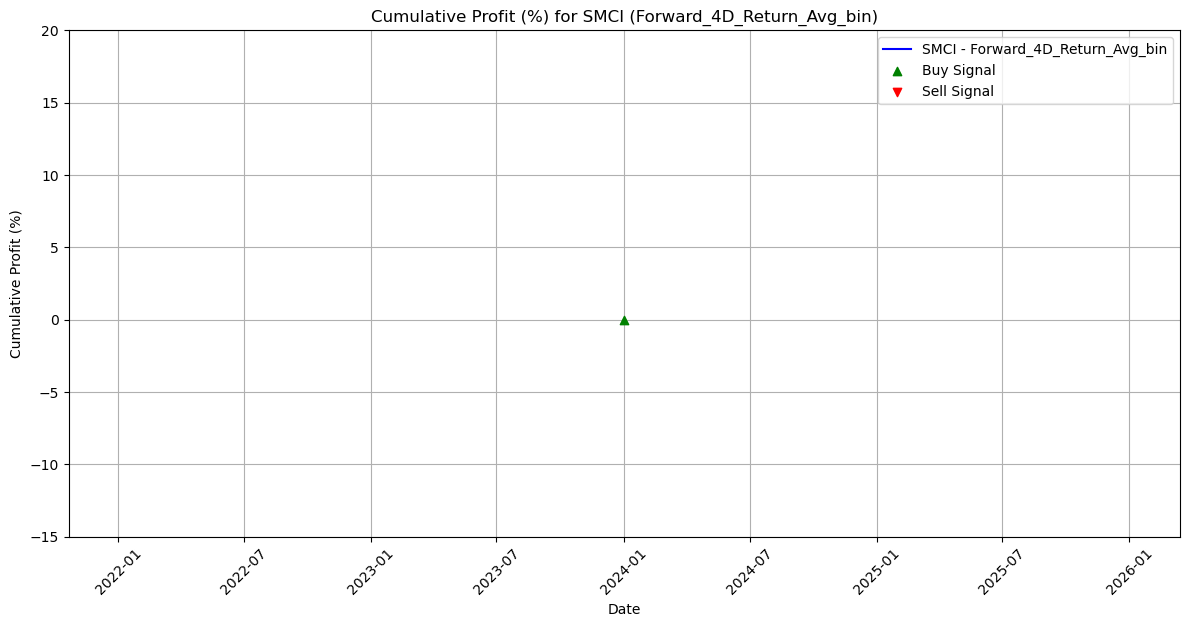

Transaction Steps for SMCI (Forward_4D_Return_Avg_bin):
Buy Signal 84: Bought at 283.3 on 2024-01-02
Hit Rate: 0.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



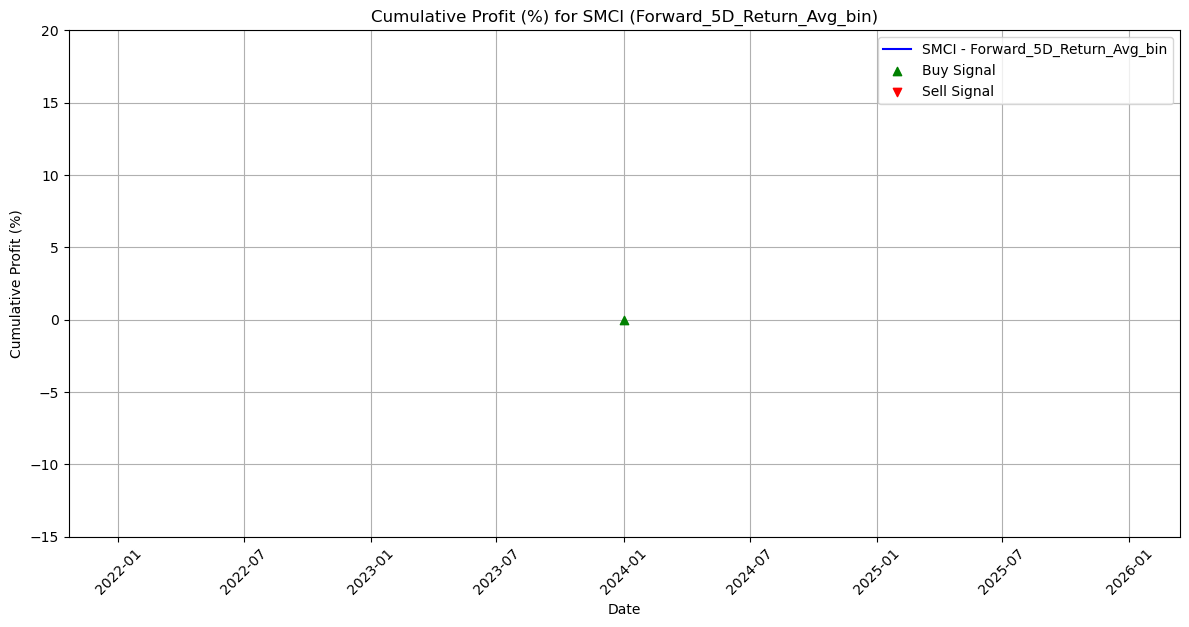

Transaction Steps for SMCI (Forward_5D_Return_Avg_bin):
Buy Signal 84: Bought at 283.3 on 2024-01-02
Hit Rate: 0.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



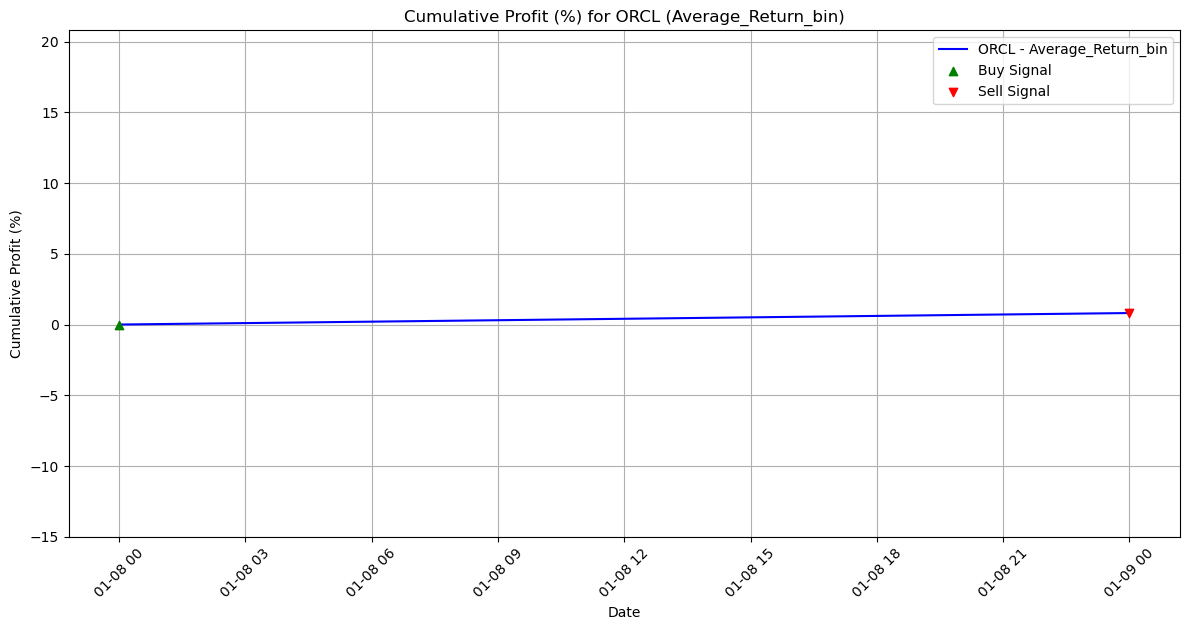

Transaction Steps for ORCL (Average_Return_bin):
Buy Signal 34: Bought at 103.42 on 2024-01-08
Sell Signal 57: Sold at 104.26 on 2024-01-09
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------

No valid data to plot for ORCL - Forward_1D_Return_Avg_bin.


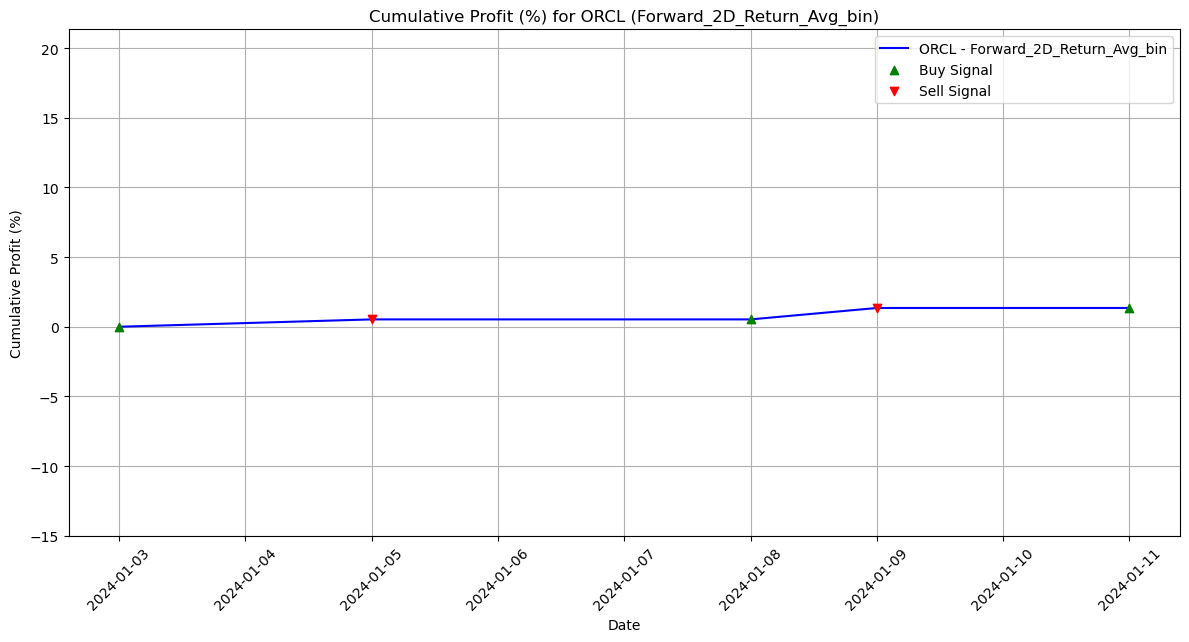

Transaction Steps for ORCL (Forward_2D_Return_Avg_bin):
Buy Signal 53: Bought at 102.45 on 2024-01-03
Sell Signal 48: Sold at 102.99 on 2024-01-05
Buy Signal 34: Bought at 103.42 on 2024-01-08
Sell Signal 57: Sold at 104.26 on 2024-01-09
Buy Signal 72: Bought at 104.18 on 2024-01-11
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



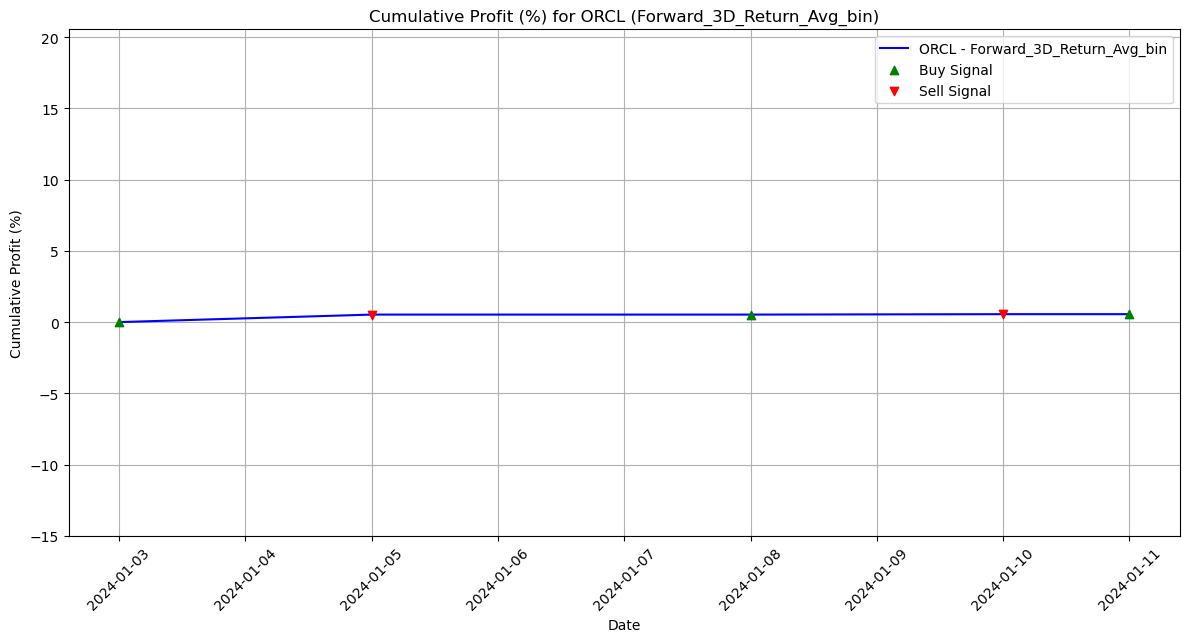

Transaction Steps for ORCL (Forward_3D_Return_Avg_bin):
Buy Signal 53: Bought at 102.45 on 2024-01-03
Sell Signal 48: Sold at 102.99 on 2024-01-05
Buy Signal 34: Bought at 103.42 on 2024-01-08
Sell Signal 51: Sold at 103.45 on 2024-01-10
Buy Signal 72: Bought at 104.18 on 2024-01-11
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



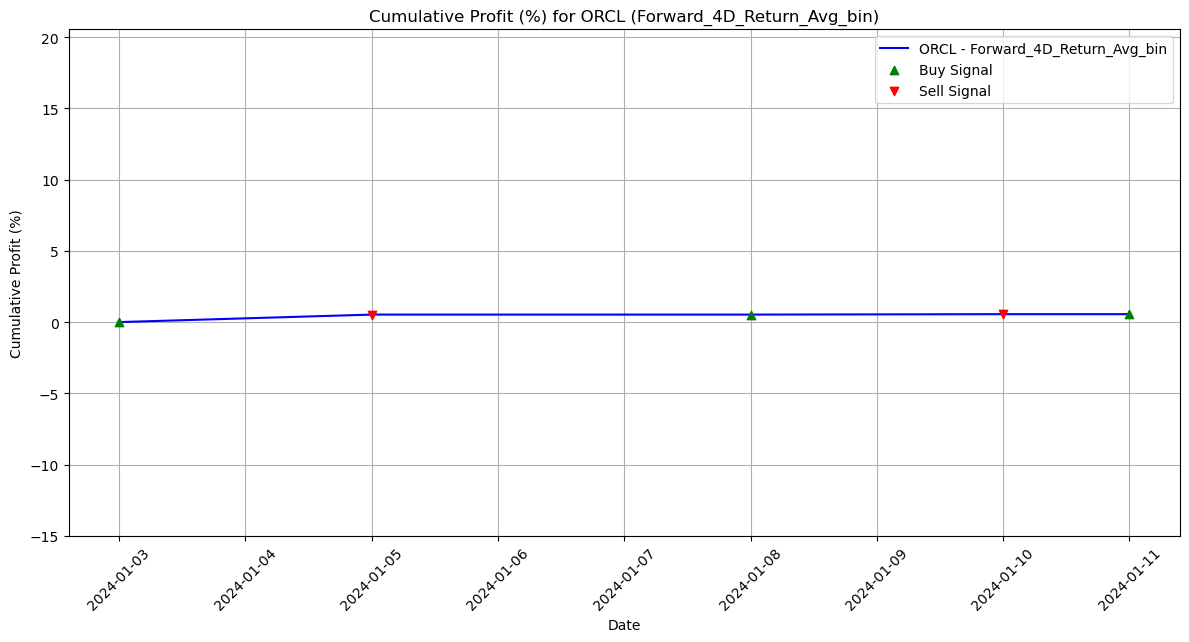

Transaction Steps for ORCL (Forward_4D_Return_Avg_bin):
Buy Signal 53: Bought at 102.45 on 2024-01-03
Sell Signal 48: Sold at 102.99 on 2024-01-05
Buy Signal 34: Bought at 103.42 on 2024-01-08
Sell Signal 51: Sold at 103.45 on 2024-01-10
Buy Signal 72: Bought at 104.18 on 2024-01-11
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------



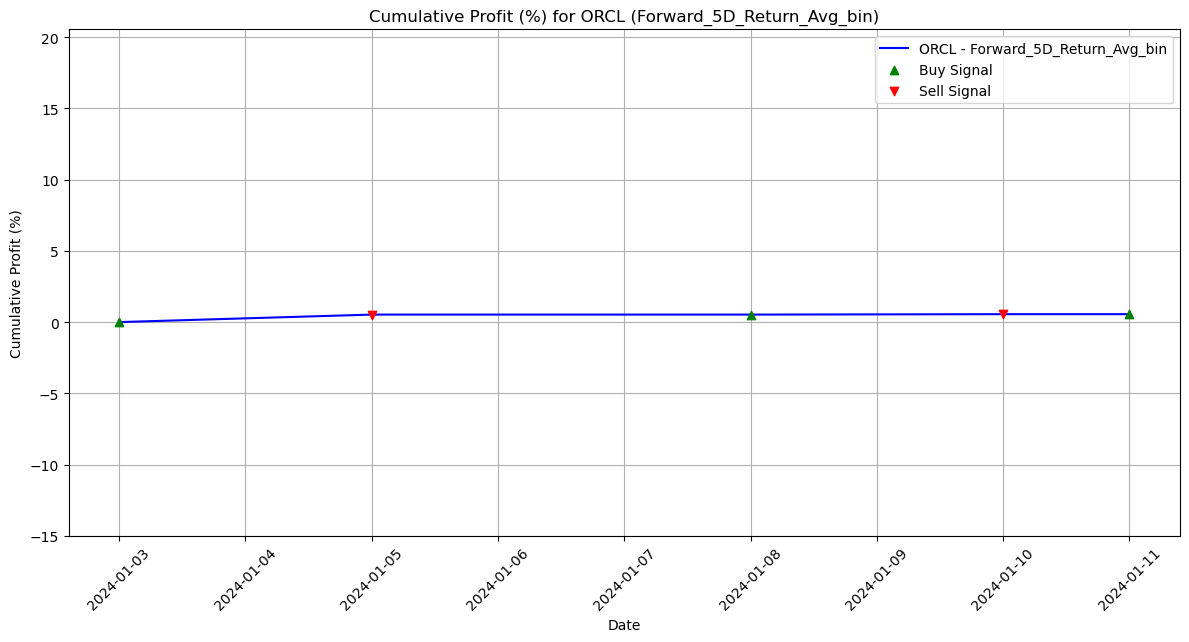

Transaction Steps for ORCL (Forward_5D_Return_Avg_bin):
Buy Signal 53: Bought at 102.45 on 2024-01-03
Sell Signal 48: Sold at 102.99 on 2024-01-05
Buy Signal 34: Bought at 103.42 on 2024-01-08
Sell Signal 51: Sold at 103.45 on 2024-01-10
Buy Signal 72: Bought at 104.18 on 2024-01-11
Hit Rate: 100.00%
Maximum Drawdown: 0.00%

--------------------------------------------------


Global Metrics Across All Tickers:

Strategy: Average_Return_bin
Global Hit Rate: 44.44%
Global Maximum Drawdown: 54.79%
--------------------------------------------------

Strategy: Forward_2D_Return_Avg_bin
Global Hit Rate: 60.00%
Global Maximum Drawdown: 23.23%
--------------------------------------------------

Strategy: Forward_3D_Return_Avg_bin
Global Hit Rate: 66.67%
Global Maximum Drawdown: 18.82%
--------------------------------------------------

Strategy: Forward_4D_Return_Avg_bin
Global Hit Rate: 62.50%
Global Maximum Drawdown: 24.06%
--------------------------------------------------

Strategy: Forwa

In [11]:
# Function to calculate drawdown
def calculate_drawdown(profit_over_time):
    max_value = float('-inf')
    max_drawdown = 0
    for profit in profit_over_time:
        if profit > max_value:
            max_value = profit
        drawdown = max_value - profit
        max_drawdown = max(max_drawdown, drawdown)
    return max_drawdown

# Initialize global metrics
global_results = {}

# Group by ticker
tickers = df_combined_backtest['Stock'].unique()

for ticker in tickers:
    # Filter data for the current ticker
    ticker_data = df_combined_backtest[df_combined_backtest['Stock'] == ticker].copy()
    ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])  # Ensure 'Date' is in datetime format

    for strategy in buy_signals.keys():  # Iterate through each trading strategy
        initial_investment = None  # Initial investment to be set at the first buy
        cumulative_profit = 0  # Start cumulative profit at 0
        profit_over_time = []  # To track percentage profit
        trade_dates = []  # To track trade dates for plotting
        current_position = None  # Track if we are in a buy or hold state

        # For plotting buy/sell markers
        buy_points = []
        sell_points = []
        transaction_steps = []  # To store the steps of each transaction
        profitable_trades = 0
        total_trades = 0

        # Loop through the data rows with a trade index
        for _, row in ticker_data.iterrows():
            signal_number = row['anonymous signal']

            # Check if the signal is in the buy signals for the current strategy
            if current_position is None and signal_number in buy_signals[strategy]:
                current_position = row['strike_price']  # Buy at this price
                if initial_investment is None:
                    initial_investment = current_position  # Set the initial investment
                buy_points.append((row['Date'], (cumulative_profit / initial_investment) * 100))  # Log the buy point
                trade_dates.append(row['Date'])  # Track the trade date
                profit_over_time.append((cumulative_profit / initial_investment) * 100)  # Log profit percentage
                transaction_steps.append(
                    f"Buy Signal {signal_number}: Bought at {row['strike_price']} on {row['Date'].strftime('%Y-%m-%d')}"
                )

            # Check if the signal is in the sell signals for the current strategy
            elif current_position is not None and signal_number in sell_signals[strategy]:
                # Sell and calculate the profit in dollars
                trade_profit = row['strike_price'] - current_position
                cumulative_profit += trade_profit  # Update cumulative profit
                profit_over_time.append((cumulative_profit / initial_investment) * 100)  # Log profit percentage
                sell_points.append((row['Date'], (cumulative_profit / initial_investment) * 100))  # Log the sell point
                trade_dates.append(row['Date'])  # Track the trade date
                transaction_steps.append(
                    f"Sell Signal {signal_number}: Sold at {row['strike_price']} on {row['Date'].strftime('%Y-%m-%d')}"
                )
                current_position = None  # Reset position after selling

                # Update hit rate metrics
                total_trades += 1
                if trade_profit > 0:
                    profitable_trades += 1

        # Ensure that trade_dates and profit_over_time have matching lengths
        if len(trade_dates) != len(profit_over_time):
            print(f"Skipping {ticker} - {strategy} due to mismatched data lengths.")
            continue

        # Handle the case where no valid data exists for plotting
        if not trade_dates or not profit_over_time:
            print(f"No valid data to plot for {ticker} - {strategy}.")
            continue

        # Calculate hit rate and drawdown
        hit_rate = (profitable_trades / total_trades * 100) if total_trades > 0 else 0
        max_drawdown = calculate_drawdown(profit_over_time)

        # Store global metrics
        if strategy not in global_results:
            global_results[strategy] = {
                "profitable_trades": 0,
                "total_trades": 0,
                "max_drawdown": 0
            }

        global_results[strategy]["profitable_trades"] += profitable_trades
        global_results[strategy]["total_trades"] += total_trades
        global_results[strategy]["max_drawdown"] = max(
            global_results[strategy]["max_drawdown"], max_drawdown
        )

        # Plot cumulative profit percentage for the current strategy
        plt.figure(figsize=(12, 6))
        plt.plot(trade_dates, profit_over_time, label=f'{ticker} - {strategy}', color='blue')
        buy_dates, buy_profits = zip(*buy_points) if buy_points else ([], [])
        sell_dates, sell_profits = zip(*sell_points) if sell_points else ([], [])
        plt.scatter(buy_dates, buy_profits, color='green', label='Buy Signal', zorder=5, marker='^')
        plt.scatter(sell_dates, sell_profits, color='red', label='Sell Signal', zorder=5, marker='v')

        # Add margins to the y-axis for better visibility
        plt.ylim(min(profit_over_time) - 15, max(profit_over_time) + 20)

        plt.title(f'Cumulative Profit (%) for {ticker} ({strategy})')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Profit (%)')
        plt.legend()
        plt.grid()
        plt.tight_layout()  # Ensure layout fits well
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.show()

        # Print the transaction steps below the graph
        print(f"Transaction Steps for {ticker} ({strategy}):")
        for step in transaction_steps:
            print(step)

        # Print hit rate and drawdown
        print(f"Hit Rate: {hit_rate:.2f}%")
        print(f"Maximum Drawdown: {max_drawdown:.2f}%")
        print("\n" + "-" * 50 + "\n")

# Print global metrics for all strategies
print("\nGlobal Metrics Across All Tickers:")
for strategy, metrics in global_results.items():
    global_hit_rate = (
        metrics["profitable_trades"] / metrics["total_trades"] * 100
        if metrics["total_trades"] > 0 else 0
    )
    print(f"\nStrategy: {strategy}")
    print(f"Global Hit Rate: {global_hit_rate:.2f}%")
    print(f"Global Maximum Drawdown: {metrics['max_drawdown']:.2f}%")
    print("-" * 50)
